In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

from tqdm import tqdm
from IPython.display import display

from sklearn import base
from sklearn import pipeline as pip
from sklearn import impute as imp
from sklearn import preprocessing as pre
from sklearn import compose as com
from sklearn import model_selection as mod

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [2]:
df = pd.read_csv("preprocessed_data_2.csv")
df.head()

,customer_num,quarter,sales,log,establishment_date,number_of_emp,sector,region,total_risk,total_limit,totalRiskT1,totalRiskT2,totalRiskT3,totalRiskT4,totalLimitT1,totalLimitT2,totalLimitT3,totalLimitT4,companyAge
0,RATI9590GZD,2017Q4,NaN,2017-06-14,2001-01-26,8.0,RETAIL-WHOLESALE,Marmara Region,70614.0,7000362.0,77004.0,75002.0,67859.0,47342.0,6299583.0,6867406.0,6935723.0,5860498.0,16.94
1,RATI2539VHR,2015Q4,0.0,2015-02-20,1994-03-08,21.0,MANUFACTURING,Central Anatolia Region,682662.0,2353551.0,675909.0,709079.0,738072.0,683153.0,2188838.0,2298960.0,2137717.0,3035324.0,23.83
2,RATI4481GNN,2010Q4,0.0,2010-12-07,1996-01-27,7.0,RETAIL-WHOLESALE,Mediterranean Region,115745.0,592723.0,112913.0,105124.0,111205.0,116312.0,557378.0,507497.0,497358.0,522139.0,21.94
3,RATI4948THA,2012Q4,1.0,2012-10-02,2004-04-07,34.0,MANUFACTURING,Southeastern Anatolia Region,39234.0,2470770.0,39148.0,38039.0,37282.0,35821.0,2422098.0,2373239.0,2302184.0,2071846.0,13.74
4,RATI8841WYZ,2013Q4,0.0,2013-05-27,2006-04-24,15.0,SERVICES,Aegean Region,70894.0,505769.0,70337.0,63175.0,63554.0,80901.0,495645.0,511140.0,551499.0,556069.0,11.70


In [3]:
df.drop(["customer_num", "log", "establishment_date"], axis = 1, inplace = True)

In [4]:
df.isna().sum()

quarter             0
sales            2828
number_of_emp     175
sector              0
region              0
total_risk        116
total_limit       116
totalRiskT1       116
totalRiskT2       116
totalRiskT3       116
totalRiskT4        79
totalLimitT1      116
totalLimitT2      116
totalLimitT3      116
totalLimitT4       79
companyAge          0
dtype: int64

In [5]:
df.describe()

,sales,number_of_emp,total_risk,total_limit,totalRiskT1,totalRiskT2,totalRiskT3,totalRiskT4,totalLimitT1,totalLimitT2,totalLimitT3,totalLimitT4,companyAge
count,8507.000000,11160.000000,1.121900e+04,1.121900e+04,1.121900e+04,1.121900e+04,1.121900e+04,1.125600e+04,1.121900e+04,1.121900e+04,1.121900e+04,1.125600e+04,11335.000000
mean,0.169507,16.543011,1.005779e+06,2.534568e+06,1.004360e+06,1.011505e+06,9.832552e+05,1.101786e+06,2.546438e+06,2.562403e+06,2.543222e+06,2.539575e+06,15.912608
std,0.375222,82.639732,1.803999e+07,1.860757e+07,1.892642e+07,2.042825e+07,1.841203e+07,2.599993e+07,1.948606e+07,2.099627e+07,1.905043e+07,2.641071e+07,7.750846
min,0.000000,1.000000,0.000000e+00,2.518000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.428000e+03,2.566000e+03,2.296000e+03,3.006000e+03,1.550000
25%,0.000000,4.000000,1.195215e+05,5.137050e+05,1.190670e+05,1.187575e+05,1.178940e+05,1.191592e+05,5.126880e+05,5.135900e+05,5.112025e+05,4.760820e+05,10.010000
50%,0.000000,8.000000,3.955570e+05,1.290322e+06,3.900450e+05,3.867900e+05,3.827990e+05,3.699235e+05,1.281239e+06,1.279791e+06,1.275169e+06,1.188840e+06,14.510000
75%,0.000000,16.000000,1.005490e+06,2.934676e+06,9.932120e+05,9.907635e+05,9.775910e+05,9.304192e+05,2.934130e+06,2.918492e+06,2.929904e+06,2.674064e+06,21.030000
max,1.000000,3333.000000,1.894825e+09,1.894825e+09,1.989566e+09,2.148731e+09,1.933858e+09,1.991874e+09,1.989566e+09,2.148731e+09,1.933858e+09,1.991874e+09,118.030000


In [6]:
class EmployeeNrImputer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        self.fill_values = {}

    def fit(self, X, y=None):
        for sector, group in X.groupby('sector'):
            self.fill_values[sector] = group['number_of_emp'].median() # mean() yerine median() kullanıldı
        return self

    def transform(self, X):
        X_filled = X.copy()
        for sector, fill_value in self.fill_values.items():
            X_filled.loc[X_filled['sector'] == sector, 'number_of_emp'] = X_filled.loc[X_filled['sector'] == sector, 'number_of_emp'].fillna(fill_value)
        return X_filled

class LimitRiskImputer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        self.fill_values = {}

    def fit(self, X, y=None):
        for sector_region, group in X.groupby(['sector', 'region']):
            self.fill_values[sector_region] = group[['total_risk', 'total_limit']].mean()
        return self

    def transform(self, X):
        X_filled = X.copy()
        for sector_region, fill_value in self.fill_values.items():
            X_filled.loc[(X_filled['sector'] == sector_region[0]) & (X_filled['region'] == sector_region[1]), ['total_risk', 'total_limit']] = X_filled.loc[(X_filled['sector'] == sector_region[0]) & (X_filled['region'] == sector_region[1]), ['total_risk', 'total_limit']].fillna(fill_value)
        return X_filled
    
class ChangeCalculator(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for i in range(1, 5):
            X_transformed[f"totalLimit_pctchange_{i}period"] = (X_transformed["total_limit"] - X_transformed[f"totalLimitT{i}"])/X_transformed[f"totalLimitT{i}"]*100
            X_transformed[f"totalRisk_pctchange_{i}period"] = (X_transformed["total_risk"] - X_transformed[f"totalRiskT{i}"])/X_transformed[f"totalLimitT{i}"]*100

            change_cols = [f"totalLimit_pctchange_{i}period", f"totalRisk_pctchange_{i}period"]
            for col in change_cols:
                X_transformed.loc[(X_transformed[col].isna()) | (X_transformed[col] == np.inf) | (X_transformed[col] == -np.inf), col] = 0
        
        columns_to_drop = [f"totalRiskT{i}" for i in range(1, 5)] + [f"totalLimitT{i}" for i in range(1, 5)]
        X_transformed = X_transformed.drop(columns=columns_to_drop)
        
        return X_transformed

class RiskLimitRatioCalculator(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['risk_limit_ratio'] = X_transformed['total_risk'] / (X_transformed['total_limit'] + np.finfo(float).eps)
        return X_transformed

class CategoricalGenerator(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        
        X_transformed['OTHERS_Southeastern'] = ((X_transformed['sector'] == 'OTHERS') & 
                                  (X_transformed['region'] == 'Southeastern Anatolia Region')).astype(int)
        
        X_transformed['RETAIL_Eastern'] = ((X_transformed['sector'] == 'RETAIL-WHOLESALE') & 
                                  (X_transformed['region'] == 'Eastern Anatolia Region')).astype(int)
        
        X_transformed['MANUFACTURING_BlackSea_Central'] = ((X_transformed['sector'] == 'MANUFACTURING') & 
                                  (X_transformed['region'].isin(['Black Sea Region', 'Central Anatolia Region']))).astype(int)

        return X_transformed
    
class LogTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = np.log1p(X_copy[col].clip(lower=0))
        return X_copy
    
class OutlierClipper(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.clip_values_ = {}

    def fit(self, X, y=None):
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.clip_values_[col] = (lower_bound, upper_bound)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            lower_bound, upper_bound = self.clip_values_[col]
            X_copy[col] = X_copy[col].clip(lower_bound, upper_bound)
        return X_copy
    
class ColumnDropper(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        X_transformed = X_transformed.drop(columns=self.columns_to_drop)

        return X_transformed
    
class CustomMinMaxScaler(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.min_max_scaler = pre.MinMaxScaler()

    def fit(self, X, y=None):
        self.min_max_scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = self.min_max_scaler.transform(X[self.columns])
        return X_copy

class CustomOneHotEncoder(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.one_hot_encoder = pre.OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y=None):
        self.one_hot_encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        X_copy = X.copy()
        one_hot_encoded_cols = self.one_hot_encoder.transform(X[self.columns])
        one_hot_encoded_df = pd.DataFrame(one_hot_encoded_cols, columns=self.one_hot_encoder.get_feature_names_out(self.columns))
        
        X_copy = X_copy.drop(columns=self.columns)
        X_copy = pd.concat([X_copy, one_hot_encoded_df], axis=1)

        return X_copy

In [7]:
log_columns = ['number_of_emp', 'total_risk', 'total_limit']

IQR_columns = ["companyAge", 'totalLimit_pctchange_1period', 'totalRisk_pctchange_1period', 'totalLimit_pctchange_2period',\
               'totalRisk_pctchange_2period', 'totalLimit_pctchange_3period', 'totalRisk_pctchange_3period',\
               'totalLimit_pctchange_4period', 'totalRisk_pctchange_4period']

scale_cols = ['number_of_emp', 'total_risk', 'total_limit', 'companyAge', 'totalRisk_pctchange_1period', 'totalRisk_pctchange_2period', 'totalRisk_pctchange_3period', 'totalRisk_pctchange_4period']

lowImpactCols = ['totalLimit_pctchange_1period','totalLimit_pctchange_2period','totalLimit_pctchange_3period','totalLimit_pctchange_4period', 'quarter']

cat_cols = ["sector", "region"]

preprocessing_pipeline = pip.Pipeline([
    ('Employee_Nr_Imputer', EmployeeNrImputer()),
    ('Limit_Risk_Imputer', LimitRiskImputer()),
    ('change_calculator', ChangeCalculator()),
    ('risk_limit_ratio_calculator', RiskLimitRatioCalculator()),
    ('creatt_categorical_features', CategoricalGenerator()),
    ('outlier_clipper', OutlierClipper(IQR_columns)),
    ('log_transformer', LogTransformer(log_columns)),
    ('column_dropper', ColumnDropper(lowImpactCols)),
    ('CustomMinMaxScaler', CustomMinMaxScaler(scale_cols)),
    ('CustomOneHotEncoder', CustomOneHotEncoder(cat_cols))
])

df_transformed_final = preprocessing_pipeline.fit_transform(df)
df_transformed_final.head()

,sales,number_of_emp,total_risk,total_limit,companyAge,totalRisk_pctchange_1period,totalRisk_pctchange_2period,totalRisk_pctchange_3period,totalRisk_pctchange_4period,risk_limit_ratio,...,sector_OTHERS,sector_RETAIL-WHOLESALE,sector_SERVICES,region_Aegean Region,region_Black Sea Region,region_Central Anatolia Region,region_Eastern Anatolia Region,region_Marmara Region,region_Mediterranean Region,region_Southeastern Anatolia Region
0,NaN,0.202739,0.522647,0.586061,0.427381,0.462183,0.452887,0.453962,0.467130,0.010087,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.323220,0.628851,0.505501,0.618717,0.498473,0.377938,0.312639,0.457001,0.290056,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.186863,0.545779,0.403589,0.566232,0.516140,0.601842,0.500847,0.454735,0.195277,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.385805,0.495138,0.509093,0.338517,0.471477,0.460778,0.456382,0.461435,0.015879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.280294,0.522833,0.391864,0.281866,0.481110,0.561600,0.523298,0.413287,0.140171,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_transformed_final.isna().sum()

sales                                  2828
number_of_emp                             0
total_risk                                0
total_limit                               0
companyAge                                0
totalRisk_pctchange_1period               0
totalRisk_pctchange_2period               0
totalRisk_pctchange_3period               0
totalRisk_pctchange_4period               0
risk_limit_ratio                          0
OTHERS_Southeastern                       0
RETAIL_Eastern                            0
MANUFACTURING_BlackSea_Central            0
sector_MANUFACTURING                      0
sector_OTHERS                             0
sector_RETAIL-WHOLESALE                   0
sector_SERVICES                           0
region_Aegean Region                      0
region_Black Sea Region                   0
region_Central Anatolia Region            0
region_Eastern Anatolia Region            0
region_Marmara Region                     0
region_Mediterranean Region     

In [9]:
train = df[~df["sales"].isna()]
test = df[df["sales"].isna()]
test.drop("sales", axis = 1, inplace = True)

display(train.head())
display(test.head())

C:\Users\duruh\AppData\Local\Temp\ipykernel_11936\4243715580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop("sales", axis = 1, inplace = True)


,quarter,sales,number_of_emp,sector,region,total_risk,total_limit,totalRiskT1,totalRiskT2,totalRiskT3,totalRiskT4,totalLimitT1,totalLimitT2,totalLimitT3,totalLimitT4,companyAge
1,2015Q4,0.0,21.0,MANUFACTURING,Central Anatolia Region,682662.0,2353551.0,675909.0,709079.0,738072.0,683153.0,2188838.0,2298960.0,2137717.0,3035324.0,23.83
2,2010Q4,0.0,7.0,RETAIL-WHOLESALE,Mediterranean Region,115745.0,592723.0,112913.0,105124.0,111205.0,116312.0,557378.0,507497.0,497358.0,522139.0,21.94
3,2012Q4,1.0,34.0,MANUFACTURING,Southeastern Anatolia Region,39234.0,2470770.0,39148.0,38039.0,37282.0,35821.0,2422098.0,2373239.0,2302184.0,2071846.0,13.74
4,2013Q4,0.0,15.0,SERVICES,Aegean Region,70894.0,505769.0,70337.0,63175.0,63554.0,80901.0,495645.0,511140.0,551499.0,556069.0,11.70
6,2017Q4,0.0,8.0,MANUFACTURING,Marmara Region,107401.0,873091.0,110574.0,121806.0,110866.0,114437.0,820978.0,788409.0,740777.0,792481.0,17.55


,quarter,number_of_emp,sector,region,total_risk,total_limit,totalRiskT1,totalRiskT2,totalRiskT3,totalRiskT4,totalLimitT1,totalLimitT2,totalLimitT3,totalLimitT4,companyAge
0,2017Q4,8.0,RETAIL-WHOLESALE,Marmara Region,70614.0,7000362.0,77004.0,75002.0,67859.0,47342.0,6299583.0,6867406.0,6935723.0,5860498.0,16.94
5,2011Q4,25.0,OTHERS,Marmara Region,523623.0,1225757.0,544517.0,539410.0,517695.0,167094.0,1127057.0,1105101.0,1204655.0,358533.0,10.94
7,2012Q4,13.0,MANUFACTURING,Eastern Anatolia Region,299618.0,701820.0,281698.0,270288.0,259819.0,269912.0,771764.0,771376.0,802600.0,754086.0,19.77
12,2015Q4,5.0,RETAIL-WHOLESALE,Marmara Region,2895741.0,7150146.0,2751024.0,2503249.0,2628063.0,540186.0,7508195.0,6906977.0,7114497.0,988848.0,10.05
14,2010Q4,26.0,MANUFACTURING,Marmara Region,762961.0,2252256.0,716968.0,645411.0,683482.0,636281.0,2364747.0,2223418.0,2178638.0,2265428.0,25.95


In [10]:
y = train["sales"]
X = train.drop("sales", axis = 1)

X_train, X_test, y_train, y_test = mod.train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

display(X_train.head())
display(X_test.head())
display(y_train[:5])
display(y_test[:5])
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

,quarter,number_of_emp,sector,region,total_risk,total_limit,totalRiskT1,totalRiskT2,totalRiskT3,totalRiskT4,totalLimitT1,totalLimitT2,totalLimitT3,totalLimitT4,companyAge
3489,2016Q4,1.0,RETAIL-WHOLESALE,Marmara Region,36764.0,929913.0,33281.0,35683.0,37116.0,40106.0,966920.0,869743.0,783231.0,720506.0,8.88
7287,2015Q4,1.0,RETAIL-WHOLESALE,Black Sea Region,5230072.0,9815184.0,5020598.0,5020942.0,4719872.0,3726389.0,9422529.0,9234270.0,10157210.0,9872579.0,14.62
9696,2017Q4,37.0,OTHERS,Marmara Region,475527.0,2089109.0,503854.0,484033.0,532302.0,1133852.0,2256478.0,2459162.0,2434702.0,2087628.0,18.02
8808,2013Q4,4.0,OTHERS,Marmara Region,31531.0,116729.0,31531.0,31531.0,31531.0,31531.0,116729.0,116729.0,116729.0,116729.0,12.04
755,2011Q4,69.0,OTHERS,Marmara Region,76550.0,155124.0,82455.0,88740.0,82807.0,83819.0,158609.0,158575.0,168480.0,185170.0,9.27


,quarter,number_of_emp,sector,region,total_risk,total_limit,totalRiskT1,totalRiskT2,totalRiskT3,totalRiskT4,totalLimitT1,totalLimitT2,totalLimitT3,totalLimitT4,companyAge
6609,2017Q4,6.0,RETAIL-WHOLESALE,Marmara Region,206435.0,759891.0,201827.0,207744.0,189360.0,245713.0,767298.0,844580.0,844206.0,748079.0,9.61
5140,2011Q4,15.0,MANUFACTURING,Central Anatolia Region,1286467.0,2723103.0,1196645.0,1089336.0,1001507.0,932165.0,2858814.0,3116339.0,2866368.0,3096177.0,21.10
682,2013Q4,4.0,RETAIL-WHOLESALE,Central Anatolia Region,53284.0,461587.0,57480.0,60314.0,62715.0,58404.0,488660.0,440477.0,396106.0,403818.0,10.78
7197,2013Q4,4.0,RETAIL-WHOLESALE,Central Anatolia Region,18954.0,270958.0,19171.0,20109.0,18179.0,15691.0,295656.0,297990.0,295549.0,268162.0,22.96
578,2012Q4,5.0,RETAIL-WHOLESALE,Marmara Region,366336.0,4618775.0,333165.0,319844.0,307882.0,282682.0,5080230.0,4775787.0,4346330.0,4780217.0,9.10


3489    0.0
7287    0.0
9696    0.0
8808    0.0
755     0.0
Name: sales, dtype: float64

6609    0.0
5140    0.0
682     0.0
7197    0.0
578     0.0
Name: sales, dtype: float64

sales
0.0    0.830534
1.0    0.169466
Name: proportion, dtype: float64

sales
0.0    0.830396
1.0    0.169604
Name: proportion, dtype: float64

In [11]:
from sklearn import linear_model as lin
from sklearn import neighbors as nei
from sklearn import svm
from sklearn import ensemble as ens
from xgboost import XGBClassifier
from sklearn import metrics as met

In [12]:
classifiers = [
    lin.LogisticRegression(),
    nei.KNeighborsClassifier(),
    svm.SVC(probability=True, random_state=42),
    ens.RandomForestClassifier(),
    ens.GradientBoostingClassifier(),
    XGBClassifier()
]

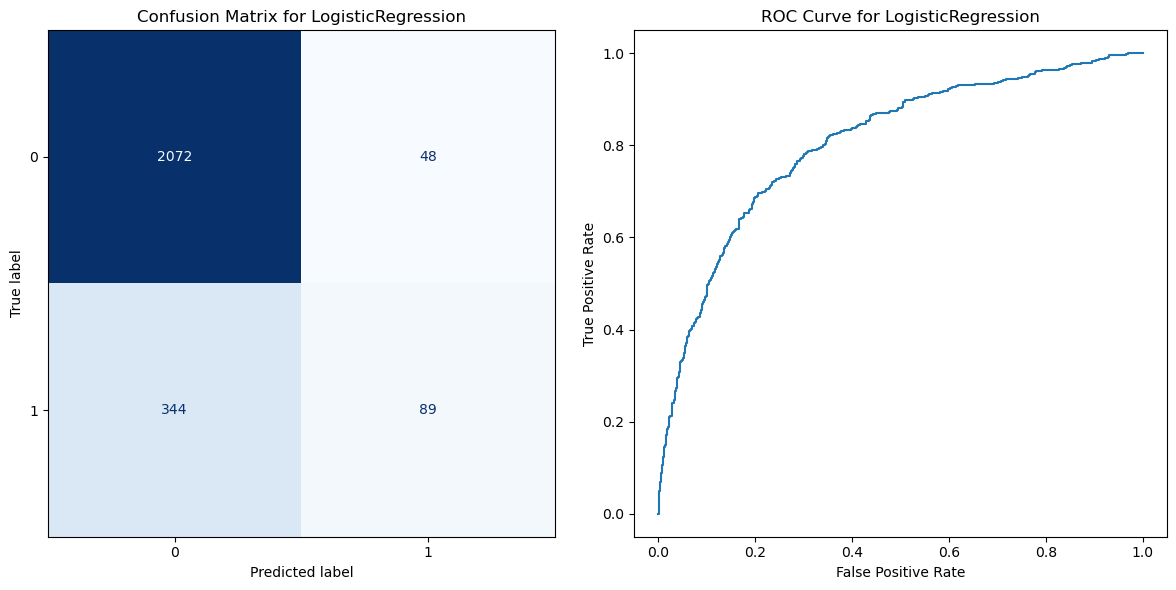

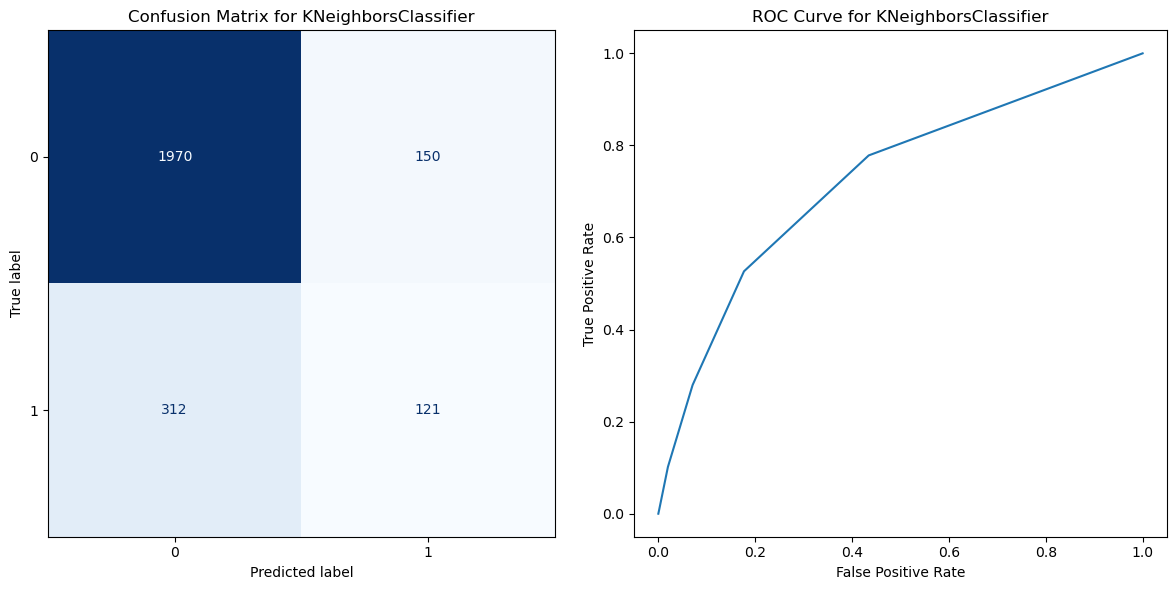

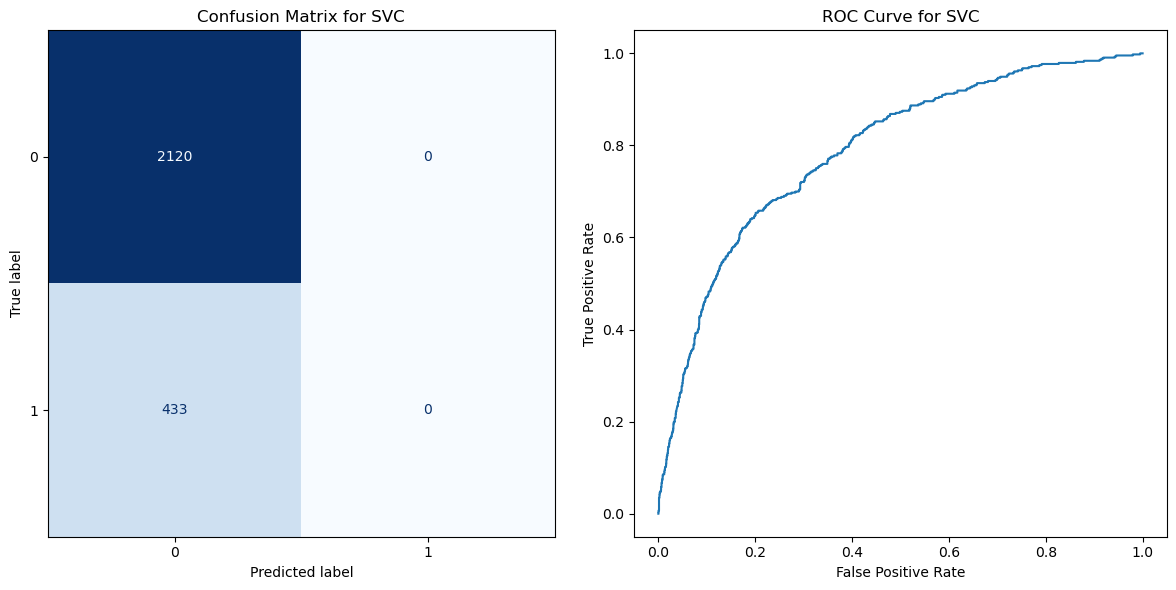

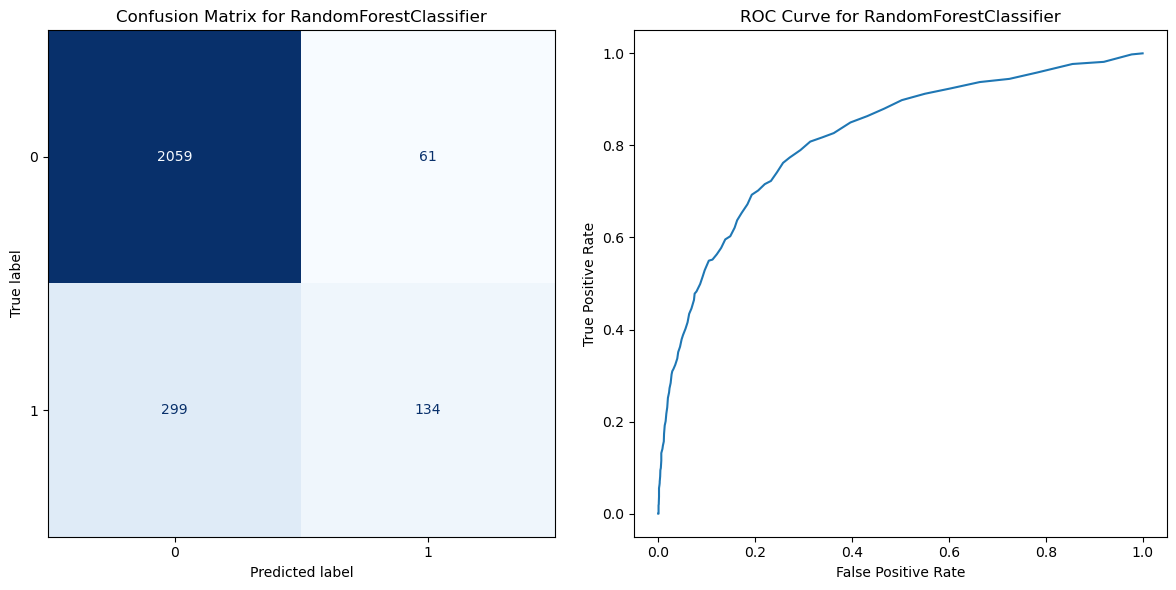

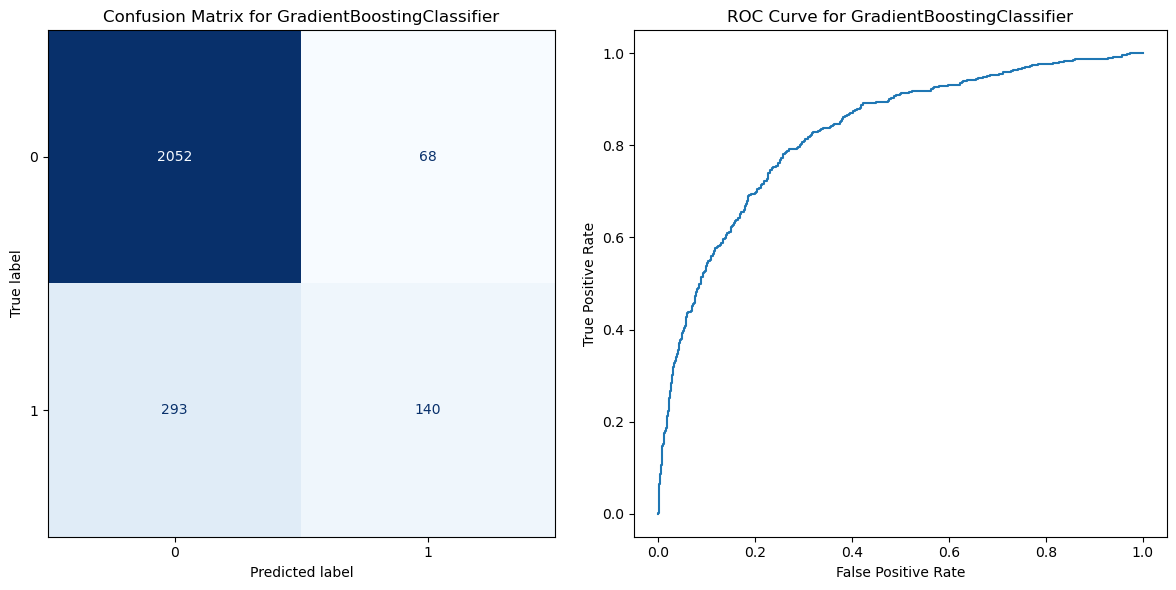

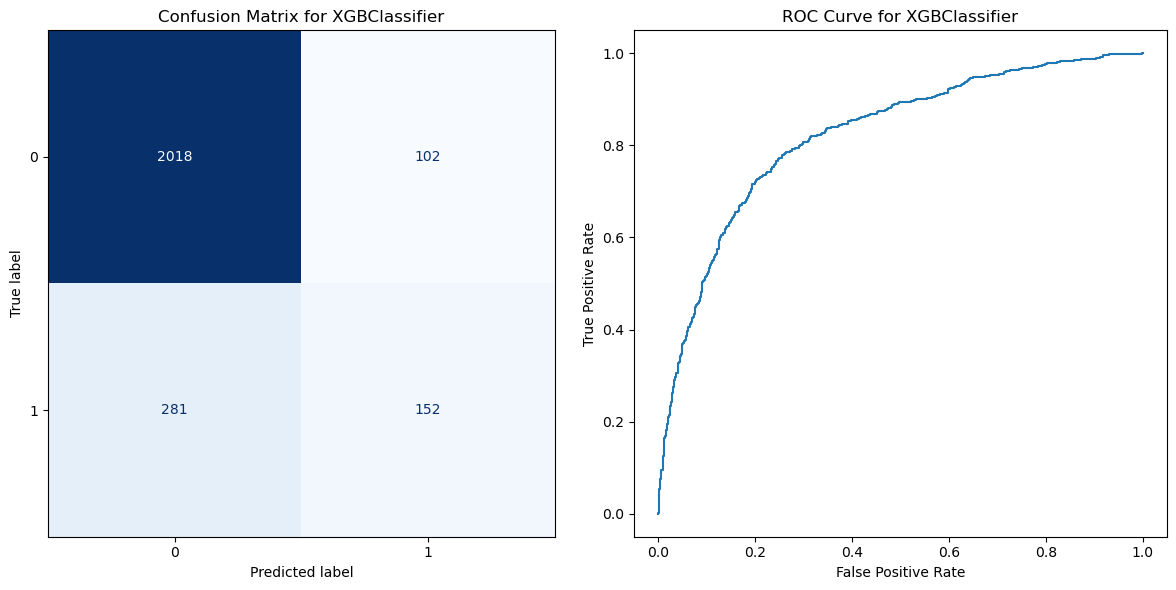

In [13]:
X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
X_test_transformed = preprocessing_pipeline.transform(X_test.reset_index(drop = True))

results = []

for classifier in classifiers:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    classifier.fit(X_train_transformed, y_train)
    y_pred = classifier.predict(X_test_transformed)
    y_score = classifier.predict_proba(X_test_transformed)[:, 1]
    
    cf_matrix = met.confusion_matrix(y_test, y_pred)
    disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
    disp.plot(cmap=plt.cm.Blues, ax=ax[0], colorbar=False)
    ax[0].set_title(f"Confusion Matrix for {classifier.__class__.__name__}")

    fpr, tpr, _ = met.roc_curve(y_test, y_score)
    ax[1].plot(fpr, tpr)
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title(f"ROC Curve for {classifier.__class__.__name__}")

    plt.tight_layout()
    plt.show()

In [14]:
results_base = []

for classifier in classifiers:
    classifier.fit(X_train_transformed, y_train)
    y_pred = classifier.predict(X_test_transformed)
    TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

    accuracy = met.accuracy_score(y_test, y_pred)
    precision = met.precision_score(y_test, y_pred)
    recall = met.recall_score(y_test, y_pred)
    f1 = met.f1_score(y_test, y_pred)
    roc_auc = met.roc_auc_score(y_test, y_pred)
    
    # Calculate the precision-recall AUC
    y_score = classifier.predict_proba(X_test_transformed)[:, 1]
    precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
    pr_auc = met.auc(recall_, precision_)
    
    beta = 2
    f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

    results_base.append([classifier.__class__.__name__, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results_base = pd.DataFrame(results_base, columns=["method", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])

C:\Users\duruh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duruh\AppData\Local\Temp\ipykernel_11936\2723951801.py:20: RuntimeWarning: invalid value encountered in scalar divide
  f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


In [15]:
df_results_base

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,LogisticRegression,0.846455,89,48,2072,344,0.649635,0.205543,0.591451,0.489488,0.312281,0.238095
1,KNeighborsClassifier,0.819036,121,150,1970,312,0.446494,0.279446,0.604346,0.370538,0.343750,0.302047
2,SVC,0.830396,0,0,2120,433,0.000000,0.000000,0.500000,0.445788,0.000000,NaN
3,RandomForestClassifier,0.856639,129,62,2058,304,0.675393,0.297921,0.634338,0.526672,0.413462,0.335413
4,GradientBoostingClassifier,0.858598,140,68,2052,293,0.673077,0.323326,0.645625,0.537484,0.436817,0.360825
5,XGBClassifier,0.849980,152,102,2018,281,0.598425,0.351039,0.651463,0.514830,0.442504,0.382679


RandomForestClassifier, GradientBoostingClassifier and XGBClassifier seem to perfom better in general. I will try to tune the parameters of these models.

In [16]:
classifiers = [
    ("RandomForestClassifier_CV", ens.RandomForestClassifier(), {'n_estimators': [100, 200, 500], 
                                                              'max_depth': [None, 10, 20, 30], 
                                                              'min_samples_split': [2, 5, 10]}),
    ("GradientBoostingClassifier_CV", ens.GradientBoostingClassifier(), {'n_estimators': [100, 200, 500],
                                                                      'learning_rate': [0.01, 0.1, 1],
                                                                      'max_depth': [3, 5, 8]}),
    ("XGBClassifier_CV", XGBClassifier(eval_metric='logloss'), {'n_estimators': [100, 200, 500],
                                                              'learning_rate': [0.01, 0.1, 1],
                                                              'max_depth': [3, 5, 8]})
]

results_cv = []

for name, classifier, params in classifiers:
    clf = mod.GridSearchCV(classifier, params, cv=3, scoring='f1', verbose=0, n_jobs=-1)
    clf.fit(X_train_transformed, y_train)
    best_clf = clf.best_estimator_
    
    y_pred = best_clf.predict(X_test_transformed)
    TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

    accuracy = met.accuracy_score(y_test, y_pred)
    precision = met.precision_score(y_test, y_pred)
    recall = met.recall_score(y_test, y_pred)
    f1 = met.f1_score(y_test, y_pred)
    roc_auc = met.roc_auc_score(y_test, y_pred)
    
    y_score = best_clf.predict_proba(X_test_transformed)[:, 1]
    precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
    pr_auc = met.auc(recall_, precision_)
    
    beta = 2
    f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

    results_cv.append([name, clf.best_params_, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])
    print(f"Calculations are completed for {name}.")

df_results_cv = pd.DataFrame(results_cv, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results_cv = df_results_cv[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]

Calculations are completed for RandomForestClassifier_CV.
Calculations are completed for GradientBoostingClassifier_CV.
Calculations are completed for XGBClassifier_CV.


In [17]:
df_results_cv

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,RandomForestClassifier_CV,0.860556,133,56,2064,300,0.703704,0.307159,0.640372,0.536414,0.427653,0.346174,"{'max_depth': 20, 'min_samples_split': 2, 'n_e..."
1,GradientBoostingClassifier_CV,0.852722,144,87,2033,289,0.623377,0.332564,0.645763,0.523576,0.433735,0.366786,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
2,XGBClassifier_CV,0.840188,157,132,1988,276,0.543253,0.362587,0.650161,0.468957,0.434903,0.388422,"{'learning_rate': 1, 'max_depth': 5, 'n_estima..."


In [28]:
def plot_learning_curve(estimator, X, y, name, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # creates a subplot with 1 row, 2 columns

    for ax, scoring in zip(axes, ["f1", "accuracy"]):
        train_sizes, train_scores, test_scores = mod.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        ax.grid()
        ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax.set_title(f"Learning curve of {name} ({scoring})")
        ax.set_xlabel("Training examples")
        ax.set_ylabel(f"{scoring.capitalize()} Score")
        ax.legend(loc="best")

    plt.tight_layout()

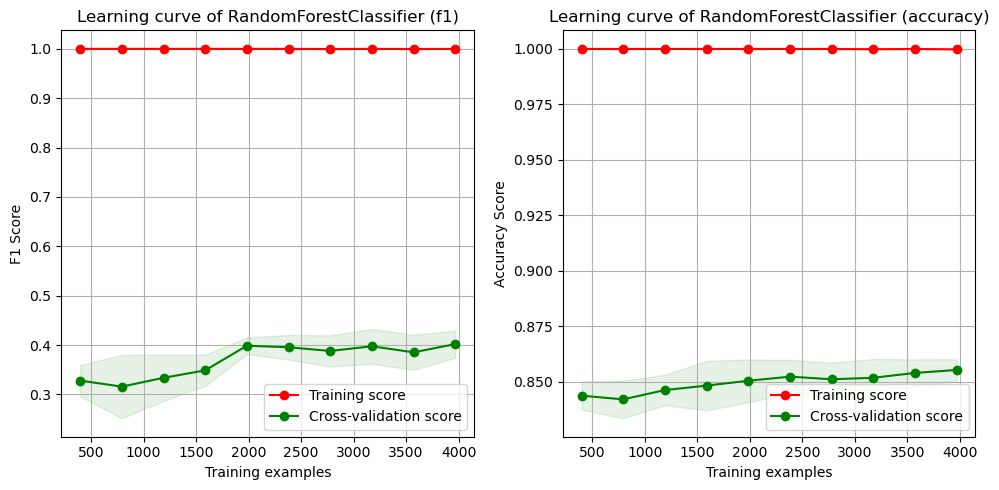

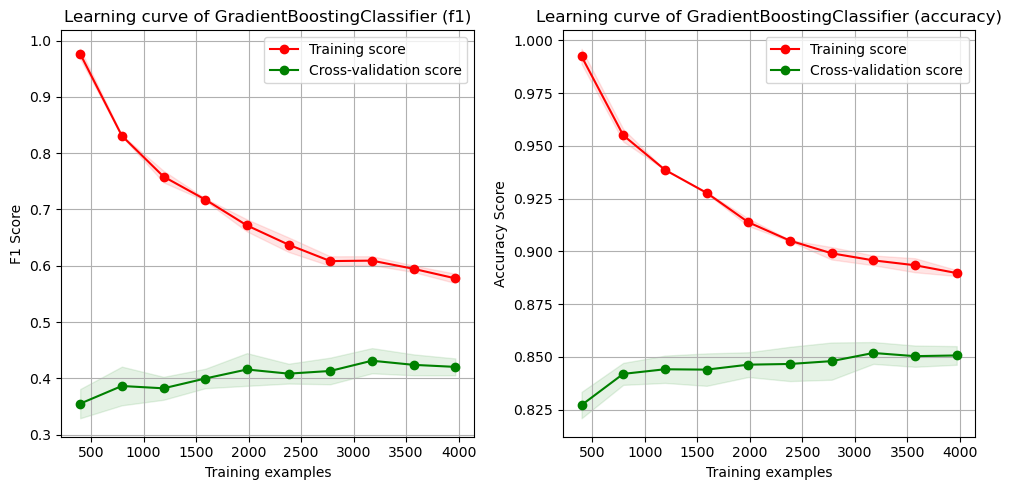

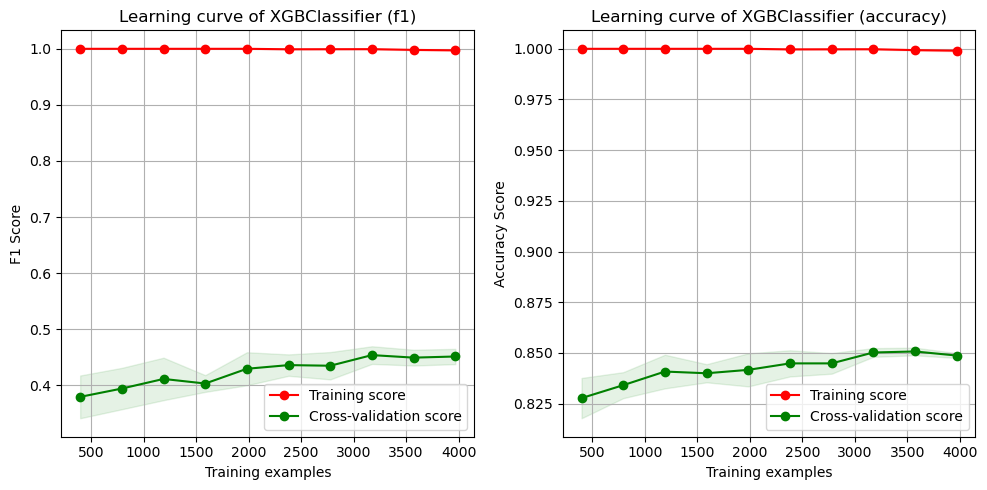

In [29]:
classifiers = [
    ens.RandomForestClassifier(),
    ens.GradientBoostingClassifier(),
    XGBClassifier()
]

for classifier in classifiers:
    plot_learning_curve(classifier, X_train_transformed, y_train, name = classifier.__class__.__name__, cv = 3, n_jobs = -1)

In [30]:
def objective(trial: Trial, X, y):

    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'max_depth': trial.suggest_int('max_depth', 4, 6),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train, eval_set=[(X_valid_transformed, y_valid)], early_stopping_rounds=30, verbose=False)

    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params = study.best_params
print(best_params)

[I 2023-07-21 17:15:13,833] A new study created in memory with name: no-name-406e58cc-7c01-4be4-ba79-8b1ca677ebe2
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:15:14,393] Trial 0 finished with value: 0.4359351988217967 and parameters: {'n_estimators': 475, 'learning_rate': 0.19260714596148742, 'max_depth': 6, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 0.4359351988217967.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:15:15,349] Trial 1 finished with value: 0.4326777609682

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:15:26,765] Trial 15 finished with value: 0.46222222222222226 and parameters: {'n_estimators': 443, 'learning_rate': 0.11068098404334686, 'max_depth': 4, 'subsample': 0.862538691113949, 'colsample_bytree': 0.8304278626461434}. Best is trial 7 with value: 0.4961948249619482.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:15:27,539] Trial 16 finished with value: 0.46879756468797573 and parameters: {'n_estimators': 400, 'learning_rate': 0.14528004436652114, 'max_depth': 5, 'subsample': 0.

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:15:38,158] Trial 30 finished with value: 0.46455505279034687 and parameters: {'n_estimators': 490, 'learning_rate': 0.18155361545863574, 'max_depth': 4, 'subsample': 0.875159466930709, 'colsample_bytree': 0.7362948265228579}. Best is trial 7 with value: 0.4961948249619482.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:15:39,096] Trial 31 finished with value: 0.4229607250755287 and parameters: {'n_estimators': 518, 'learning_rate': 0.09146551647608321, 'max_depth': 6, 'subsample': 0.9

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:15:51,189] Trial 45 finished with value: 0.4610951008645533 and parameters: {'n_estimators': 588, 'learning_rate': 0.08168566965117291, 'max_depth': 6, 'subsample': 0.7940765929351431, 'colsample_bytree': 0.6421585777238812}. Best is trial 43 with value: 0.49789029535864987.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:15:51,890] Trial 46 finished with value: 0.41587301587301584 and parameters: {'n_estimators': 496, 'learning_rate': 0.0754873820729598, 'max_depth': 4, 'subsample': 0

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:16:03,828] Trial 60 finished with value: 0.46697388632872505 and parameters: {'n_estimators': 575, 'learning_rate': 0.05101743201407776, 'max_depth': 4, 'subsample': 0.7085866952229227, 'colsample_bytree': 0.7420315335059016}. Best is trial 43 with value: 0.49789029535864987.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:16:04,681] Trial 61 finished with value: 0.4633093525179856 and parameters: {'n_estimators': 566, 'learning_rate': 0.05547875347161474, 'max_depth': 6, 'subsample': 

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:16:16,912] Trial 75 finished with value: 0.4127465857359636 and parameters: {'n_estimators': 592, 'learning_rate': 0.06969434251220806, 'max_depth': 6, 'subsample': 0.8172651187944682, 'colsample_bytree': 0.6751618245775683}. Best is trial 43 with value: 0.49789029535864987.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:16:17,603] Trial 76 finished with value: 0.4362017804154303 and parameters: {'n_estimators': 544, 'learning_rate': 0.0809785166102981, 'max_depth': 6, 'subsample': 0.

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:16:30,032] Trial 90 finished with value: 0.45441389290882783 and parameters: {'n_estimators': 561, 'learning_rate': 0.10490390570936524, 'max_depth': 4, 'subsample': 0.856739648654581, 'colsample_bytree': 0.667672076554241}. Best is trial 43 with value: 0.49789029535864987.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:16:31,003] Trial 91 finished with value: 0.4829545454545454 and parameters: {'n_estimators': 510, 'learning_rate': 0.0888785756475891, 'max_depth': 4, 'subsample': 0.9

{'n_estimators': 540, 'learning_rate': 0.08437320700661881, 'max_depth': 6, 'subsample': 0.8244888037019686, 'colsample_bytree': 0.6725734595605845}


In [31]:
results = []

clf = XGBClassifier(**best_params)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 1", best_params, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.62249,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."


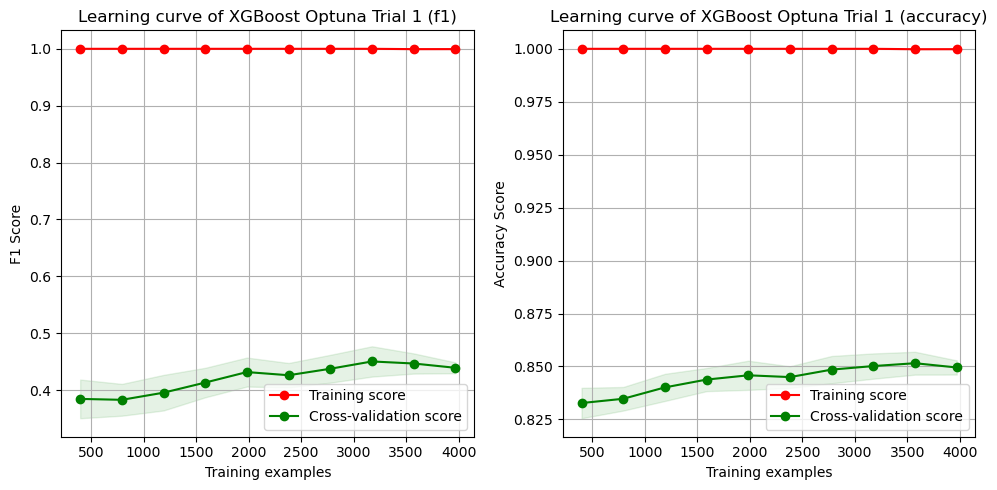

In [32]:
plot_learning_curve(XGBClassifier(**best_params), X_train_transformed, y_train, "XGBoost Optuna Trial 1", cv=3, n_jobs=-1)

In [33]:
def objective(trial: Trial, X, y):

    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train, eval_set=[(X_valid_transformed, y_valid)], early_stopping_rounds=30, verbose=False)

    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params2 = study.best_params
print(best_params2)

[I 2023-07-21 17:17:03,243] A new study created in memory with name: no-name-914273a5-38a3-484b-9310-b2b9d49c795e
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:17:03,754] Trial 0 finished with value: 0.4124031007751938 and parameters: {'n_estimators': 437, 'learning_rate': 0.28570714885887566, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.40921304830970556, 'gamma': 0.15599452033620265, 'min_child_weight': 1}. Best is trial 0 with value: 0.4124031007751938.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:1

[I 2023-07-21 17:17:15,584] Trial 13 finished with value: 0.4608819345661451 and parameters: {'n_estimators': 109, 'learning_rate': 0.1459245134774743, 'max_depth': 6, 'subsample': 0.7698100534013989, 'colsample_bytree': 0.6680696601621738, 'gamma': 0.2329934839499606, 'min_child_weight': 4}. Best is trial 2 with value: 0.47447447447447444.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:17:16,685] Trial 14 finished with value: 0.4685212298682284 and parameters: {'n_estimators': 686, 'learning_rate': 0.05517730002602379, 'max_depth': 6, 'subsample': 0.9056421932528459, 'colsample_bytree': 0.8585873929416767, 'gamma': 0.39895929718431183, 'min_child_weight': 8}. Best is trial 2 with value: 0.47447447447447444.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:17:28,721] Trial 27 finished with value: 0.4207221350078493 and parameters: {'n_estimators': 240, 'learning_rate': 0.09034329151057809, 'max_depth': 7, 'subsample': 0.7833119561480761, 'colsample_bytree': 0.7226044638367264, 'gamma': 0.15684117707469436, 'min_child_weight': 9}. Best is trial 2 with value: 0.47447447447447444.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:17:29,466] Trial 28 finished with value: 0.5084745762711864 and parameters: {'n_estimators': 329, 'learning_rate':

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:17:38,672] Trial 41 finished with value: 0.4313725490196078 and parameters: {'n_estimators': 253, 'learning_rate': 0.16182812025805848, 'max_depth': 8, 'subsample': 0.8466743730518109, 'colsample_bytree': 0.9525722103609584, 'gamma': 0.6734825671189522, 'min_child_weight': 3}. Best is trial 28 with value: 0.5084745762711864.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:17:39,331] Trial 42 finished with value: 0.4783216783216783 and parameters: {'n_estimators': 211, 'learning_rate': 

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:17:50,871] Trial 55 finished with value: 0.4549483013293944 and parameters: {'n_estimators': 132, 'learning_rate': 0.0709474711099296, 'max_depth': 8, 'subsample': 0.7587119183351068, 'colsample_bytree': 0.9158296616485995, 'gamma': 0.5350168257513159, 'min_child_weight': 9}. Best is trial 28 with value: 0.5084745762711864.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:17:51,795] Trial 56 finished with value: 0.5108225108225108 and parameters: {'n_estimators': 268, 'learning_rate': 0

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:18:05,512] Trial 69 finished with value: 0.4682080924855491 and parameters: {'n_estimators': 467, 'learning_rate': 0.03704422390097638, 'max_depth': 10, 'subsample': 0.710109651417659, 'colsample_bytree': 0.8045217056497449, 'gamma': 0.44873880520235043, 'min_child_weight': 6}. Best is trial 56 with value: 0.5108225108225108.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:18:06,365] Trial 70 finished with value: 0.4289855072463768 and parameters: {'n_estimators': 416, 'learning_rate':

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:18:20,347] Trial 83 finished with value: 0.4709219858156028 and parameters: {'n_estimators': 461, 'learning_rate': 0.050581753803839405, 'max_depth': 7, 'subsample': 0.7308337312071327, 'colsample_bytree': 0.913715701974297, 'gamma': 0.3772963001300088, 'min_child_weight': 8}. Best is trial 56 with value: 0.5108225108225108.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:18:21,549] Trial 84 finished with value: 0.45747800586510257 and parameters: {'n_estimators': 494, 'learning_rate':

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:18:32,321] Trial 97 finished with value: 0.4816446402349486 and parameters: {'n_estimators': 280, 'learning_rate': 0.09674811661907404, 'max_depth': 10, 'subsample': 0.7639226578091867, 'colsample_bytree': 0.9243581389418254, 'gamma': 0.37022377564096776, 'min_child_weight': 8}. Best is trial 56 with value: 0.5108225108225108.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:18:33,039] Trial 98 finished with value: 0.45329249617151607 and parameters: {'n_estimators': 321, 'learning_rate

{'n_estimators': 268, 'learning_rate': 0.08408388911263198, 'max_depth': 10, 'subsample': 0.7696233966544769, 'colsample_bytree': 0.8002810409544364, 'gamma': 0.4309794491325166, 'min_child_weight': 9}


In [34]:
clf = XGBClassifier(**best_params2)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 2", best_params2, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."


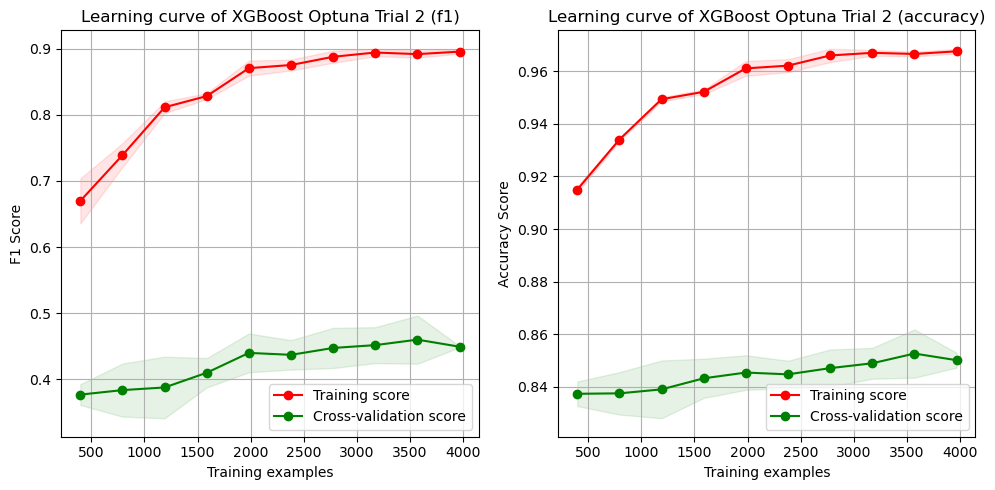

In [35]:
plot_learning_curve(XGBClassifier(**best_params2), X_train_transformed, y_train, "XGBoost Optuna Trial 2", cv=3, n_jobs=-1)

In [36]:
def objective(trial: Trial, X, y):

    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train, eval_set=[(X_valid_transformed, y_valid)], early_stopping_rounds=30, verbose=False)

    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params3 = study.best_params
print(best_params3)

[I 2023-07-21 17:18:49,545] A new study created in memory with name: no-name-88fa3bd6-7d05-4c10-9adb-6ccc23daf091
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:18:50,053] Trial 0 finished with value: 0.41379310344827586 and parameters: {'n_estimators': 437, 'learning_rate': 0.28570714885887566, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.40921304830970556, 'gamma': 0.15599452033620265, 'min_child_weight': 1}. Best is trial 0 with value: 0.41379310344827586.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17

[I 2023-07-21 17:18:59,733] Trial 13 finished with value: 0.45821325648414984 and parameters: {'n_estimators': 106, 'learning_rate': 0.2327565339709794, 'max_depth': 9, 'subsample': 0.9257188387150813, 'colsample_bytree': 0.9828004560451453, 'gamma': 0.6535368105125023, 'min_child_weight': 10}. Best is trial 7 with value: 0.4873949579831933.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:00,488] Trial 14 finished with value: 0.42152466367713004 and parameters: {'n_estimators': 319, 'learning_rate': 0.14239757342877926, 'max_depth': 9, 'subsample': 0.9064332024126299, 'colsample_bytree': 0.7135654589650925, 'gamma': 0.3979266860307149, 'min_child_weight': 8}. Best is trial 7 with value: 0.4873949579831933.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:08,735] Trial 27 finished with value: 0.42898550724637674 and parameters: {'n_estimators': 477, 'learning_rate': 0.29979510835429424, 'max_depth': 9, 'subsample': 0.8932087611551676, 'colsample_bytree': 0.9966376009194328, 'gamma': 0.004334398803704268, 'min_child_weight': 2}. Best is trial 17 with value: 0.4963715529753266.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:09,352] Trial 28 finished with value: 0.46969696969696967 and parameters: {'n_estimators': 631, 'learning_rat

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:17,196] Trial 41 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 502, 'learning_rate': 0.23681664475187775, 'max_depth': 9, 'subsample': 0.9899242678851019, 'colsample_bytree': 0.8920052175725477, 'gamma': 0.013053898787047411, 'min_child_weight': 4}. Best is trial 17 with value: 0.4963715529753266.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:17,806] Trial 42 finished with value: 0.47432024169184295 and parameters: {'n_estimators': 433, 'learning_rate

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:26,285] Trial 55 finished with value: 0.4337700145560407 and parameters: {'n_estimators': 460, 'learning_rate': 0.2384577815074391, 'max_depth': 9, 'subsample': 0.9381165652079301, 'colsample_bytree': 0.9168365226354556, 'gamma': 0.13286459142802054, 'min_child_weight': 5}. Best is trial 17 with value: 0.4963715529753266.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:26,955] Trial 56 finished with value: 0.4476744186046512 and parameters: {'n_estimators': 365, 'learning_rate': 

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:34,872] Trial 69 finished with value: 0.4441132637853949 and parameters: {'n_estimators': 995, 'learning_rate': 0.2655744703357865, 'max_depth': 7, 'subsample': 0.787903554270034, 'colsample_bytree': 0.9107047578665799, 'gamma': 0.19767543763775197, 'min_child_weight': 4}. Best is trial 17 with value: 0.4963715529753266.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:35,446] Trial 70 finished with value: 0.48929663608562696 and parameters: {'n_estimators': 303, 'learning_rate': 

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:43,295] Trial 83 finished with value: 0.4619883040935673 and parameters: {'n_estimators': 144, 'learning_rate': 0.24614083037281512, 'max_depth': 10, 'subsample': 0.977679633318097, 'colsample_bytree': 0.8600949619919541, 'gamma': 0.03278194234867141, 'min_child_weight': 8}. Best is trial 17 with value: 0.4963715529753266.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:43,912] Trial 84 finished with value: 0.4632152588555858 and parameters: {'n_estimators': 173, 'learning_rate':

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:52,022] Trial 97 finished with value: 0.4603886397608371 and parameters: {'n_estimators': 574, 'learning_rate': 0.2769718693560907, 'max_depth': 8, 'subsample': 0.9851563231364766, 'colsample_bytree': 0.9145063359828917, 'gamma': 0.0015684048087824432, 'min_child_weight': 3}. Best is trial 95 with value: 0.5178082191780822.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:19:52,648] Trial 98 finished with value: 0.4608695652173913 and parameters: {'n_estimators': 281, 'learning_rate'

{'n_estimators': 514, 'learning_rate': 0.2948266913886513, 'max_depth': 8, 'subsample': 0.9048777492261021, 'colsample_bytree': 0.9191552037408782, 'gamma': 0.003739096263823275, 'min_child_weight': 4}


In [37]:
clf = XGBClassifier(**best_params3)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 3", best_params3, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."


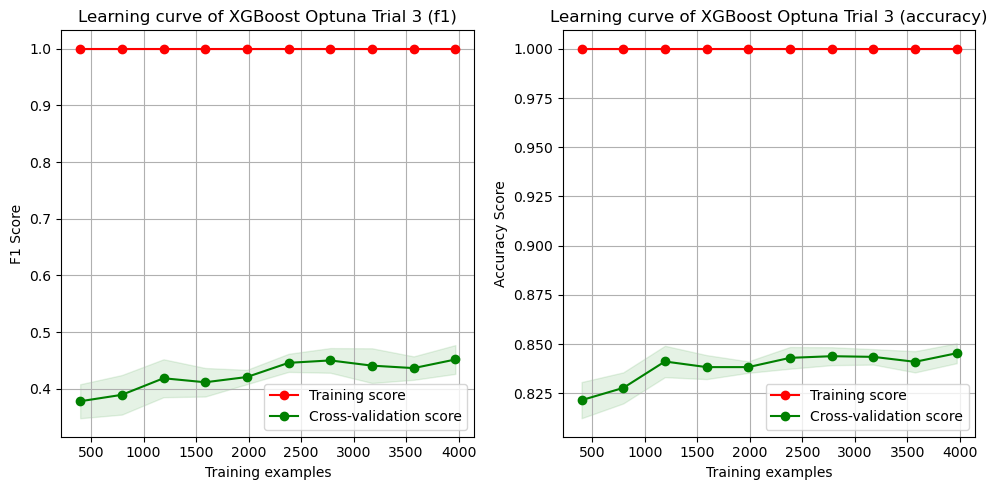

In [38]:
plot_learning_curve(XGBClassifier(**best_params3), X_train_transformed, y_train, "XGBoost Optuna Trial 3", cv=3, n_jobs=-1)

In [39]:
def objective(trial: Trial, X, y):

    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001 , 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train, eval_set=[(X_valid_transformed, y_valid)], early_stopping_rounds=30, verbose=False)

    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params4 = study.best_params
print(best_params4)

[I 2023-07-21 17:20:20,222] A new study created in memory with name: no-name-63b6a780-2205-4a30-9714-dadb6f8d69e1
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:20:20,701] Trial 0 finished with value: 0.3766233766233767 and parameters: {'n_estimators': 812, 'learning_rate': 0.2852635776165649, 'max_depth': 5, 'subsample': 0.7394633936788146, 'colsample_bytree': 0.40921304830970556, 'gamma': 0.7799726016810132, 'min_child_weight': 2}. Best is trial 0 with value: 0.3766233766233767.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:20:

[I 2023-07-21 17:20:35,217] Trial 13 finished with value: 0.4153354632587859 and parameters: {'n_estimators': 1998, 'learning_rate': 0.20289388485990742, 'max_depth': 5, 'subsample': 0.6027367300603133, 'colsample_bytree': 0.9759862028093815, 'gamma': 3.6999641737627953, 'min_child_weight': 8}. Best is trial 2 with value: 0.48296296296296304.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:20:35,930] Trial 14 finished with value: 0.4624624624624625 and parameters: {'n_estimators': 599, 'learning_rate': 0.13750646363863792, 'max_depth': 6, 'subsample': 0.6119963901081219, 'colsample_bytree': 0.7001483422569845, 'gamma': 4.981014002953378, 'min_child_weight': 20}. Best is trial 2 with value: 0.48296296296296304.
C:\Users\duruh\anaconda3\lib\site-packages\xgboos

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:20:50,065] Trial 27 finished with value: 0.426865671641791 and parameters: {'n_estimators': 1843, 'learning_rate': 0.05856979450536635, 'max_depth': 4, 'subsample': 0.7090589653371344, 'colsample_bytree': 0.7592665670750823, 'gamma': 2.602470979420654, 'min_child_weight': 26}. Best is trial 19 with value: 0.4843304843304843.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:20:50,743] Trial 28 finished with value: 0.4846625766871165 and parameters: {'n_estimators': 1144, 'learning_rate':

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:01,518] Trial 41 finished with value: 0.4411764705882353 and parameters: {'n_estimators': 962, 'learning_rate': 0.10208258119040681, 'max_depth': 5, 'subsample': 0.5586629446298241, 'colsample_bytree': 0.8544643845222687, 'gamma': 3.25351775134463, 'min_child_weight': 17}. Best is trial 28 with value: 0.4846625766871165.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:02,165] Trial 42 finished with value: 0.4728434504792332 and parameters: {'n_estimators': 839, 'learning_rate': 0

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:12,277] Trial 55 finished with value: 0.4497607655502393 and parameters: {'n_estimators': 1067, 'learning_rate': 0.11352758488116055, 'max_depth': 5, 'subsample': 0.51559394162061, 'colsample_bytree': 0.5787930777149649, 'gamma': 2.724524989226688, 'min_child_weight': 23}. Best is trial 28 with value: 0.4846625766871165.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:14,048] Trial 56 finished with value: 0.4714494875549048 and parameters: {'n_estimators': 700, 'learning_rate': 0

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:28,154] Trial 69 finished with value: 0.4653312788906009 and parameters: {'n_estimators': 1555, 'learning_rate': 0.033405572594820354, 'max_depth': 5, 'subsample': 0.5133536967361056, 'colsample_bytree': 0.8321938709719884, 'gamma': 1.2494268795903791, 'min_child_weight': 23}. Best is trial 62 with value: 0.4978165938864628.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:29,134] Trial 70 finished with value: 0.46808510638297873 and parameters: {'n_estimators': 1221, 'learning_ra

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:38,738] Trial 83 finished with value: 0.4502297090352221 and parameters: {'n_estimators': 1019, 'learning_rate': 0.15050029620540936, 'max_depth': 5, 'subsample': 0.5712554153407768, 'colsample_bytree': 0.7709386002233748, 'gamma': 2.6594561479222762, 'min_child_weight': 6}. Best is trial 74 with value: 0.5.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:39,363] Trial 84 finished with value: 0.4417910447761194 and parameters: {'n_estimators': 1505, 'learning_rate': 0.12100927416

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:47,958] Trial 97 finished with value: 0.47484276729559743 and parameters: {'n_estimators': 1263, 'learning_rate': 0.14017377393242936, 'max_depth': 5, 'subsample': 0.686127017064092, 'colsample_bytree': 0.8069176188210634, 'gamma': 2.3009436793818194, 'min_child_weight': 25}. Best is trial 74 with value: 0.5.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:21:48,605] Trial 98 finished with value: 0.4477611940298507 and parameters: {'n_estimators': 1663, 'learning_rate': 0.1352682047

{'n_estimators': 1926, 'learning_rate': 0.12281468365168827, 'max_depth': 5, 'subsample': 0.6235191902078137, 'colsample_bytree': 0.8341916333979487, 'gamma': 2.2886324737707606, 'min_child_weight': 25}


In [40]:
clf = XGBClassifier(**best_params4)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 4", best_params4, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."


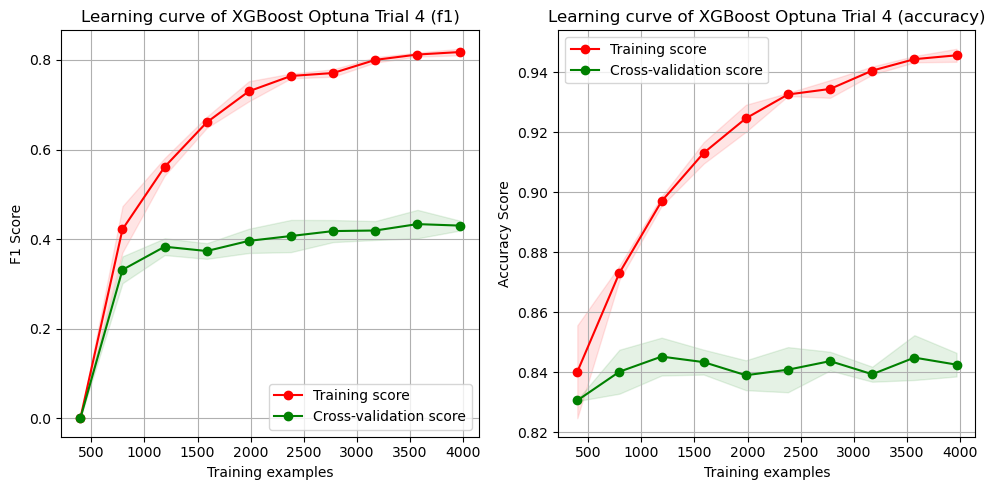

In [41]:
plot_learning_curve(XGBClassifier(**best_params4), X_train_transformed, y_train, "XGBoost Optuna Trial 4", cv=3, n_jobs=-1)

In [42]:
def objective(trial: Trial, X, y):

    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001 , 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train, eval_set=[(X_valid_transformed, y_valid)], early_stopping_rounds=30, verbose=False)

    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params5 = study.best_params
print(best_params5)

[I 2023-07-21 17:22:42,579] A new study created in memory with name: no-name-876cd559-6f00-40bd-bfaa-44c202fd70d5
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:22:43,054] Trial 0 finished with value: 0.4139020537124803 and parameters: {'n_estimators': 812, 'learning_rate': 0.2852635776165649, 'max_depth': 5, 'subsample': 0.7394633936788146, 'colsample_bytree': 0.40921304830970556, 'gamma': 0.7799726016810132, 'min_child_weight': 2}. Best is trial 0 with value: 0.4139020537124803.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:22:

[I 2023-07-21 17:22:54,080] Trial 13 finished with value: 0.47751937984496123 and parameters: {'n_estimators': 628, 'learning_rate': 0.23781183081172938, 'max_depth': 6, 'subsample': 0.844841369383179, 'colsample_bytree': 0.9831759980555426, 'gamma': 3.2676840525625117, 'min_child_weight': 11}. Best is trial 12 with value: 0.499265785609398.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:22:54,653] Trial 14 finished with value: 0.47178002894356 and parameters: {'n_estimators': 1337, 'learning_rate': 0.29767355324678013, 'max_depth': 6, 'subsample': 0.830150224546528, 'colsample_bytree': 0.7135654589650925, 'gamma': 2.02514588800305, 'min_child_weight': 23}. Best is trial 12 with value: 0.499265785609398.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\skl

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:03,301] Trial 27 finished with value: 0.38952536824877243 and parameters: {'n_estimators': 279, 'learning_rate': 0.14146415574379662, 'max_depth': 5, 'subsample': 0.8989594496507347, 'colsample_bytree': 0.7999077926139874, 'gamma': 1.1433226859593808, 'min_child_weight': 27}. Best is trial 12 with value: 0.499265785609398.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:03,984] Trial 28 finished with value: 0.4918518518518518 and parameters: {'n_estimators': 1144, 'learning_rate'

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:12,656] Trial 41 finished with value: 0.4711111111111112 and parameters: {'n_estimators': 614, 'learning_rate': 0.15105560401951784, 'max_depth': 6, 'subsample': 0.8856456496604301, 'colsample_bytree': 0.8372908891621946, 'gamma': 2.9542522143124614, 'min_child_weight': 28}. Best is trial 12 with value: 0.499265785609398.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:13,331] Trial 42 finished with value: 0.4740740740740741 and parameters: {'n_estimators': 564, 'learning_rate': 

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:21,955] Trial 55 finished with value: 0.42592592592592593 and parameters: {'n_estimators': 983, 'learning_rate': 0.222144790794705, 'max_depth': 6, 'subsample': 0.8800410912022768, 'colsample_bytree': 0.7676721376287355, 'gamma': 2.1006260451893, 'min_child_weight': 23}. Best is trial 12 with value: 0.499265785609398.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:22,702] Trial 56 finished with value: 0.42215568862275454 and parameters: {'n_estimators': 802, 'learning_rate': 0.1

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:31,867] Trial 69 finished with value: 0.49780380673499264 and parameters: {'n_estimators': 1989, 'learning_rate': 0.13376504878185352, 'max_depth': 6, 'subsample': 0.8887033680840627, 'colsample_bytree': 0.9426419808979165, 'gamma': 2.8844400093401084, 'min_child_weight': 29}. Best is trial 12 with value: 0.499265785609398.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:32,630] Trial 70 finished with value: 0.49039881831610044 and parameters: {'n_estimators': 1736, 'learning_rat

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:42,693] Trial 83 finished with value: 0.48170731707317066 and parameters: {'n_estimators': 1920, 'learning_rate': 0.12309382147818705, 'max_depth': 6, 'subsample': 0.8692070344026429, 'colsample_bytree': 0.8974088039994895, 'gamma': 2.9157155071029277, 'min_child_weight': 29}. Best is trial 12 with value: 0.499265785609398.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:43,446] Trial 84 finished with value: 0.46783625730994155 and parameters: {'n_estimators': 1275, 'learning_rat

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:52,766] Trial 97 finished with value: 0.451219512195122 and parameters: {'n_estimators': 1685, 'learning_rate': 0.17420928471897953, 'max_depth': 6, 'subsample': 0.836746889367149, 'colsample_bytree': 0.9266605107317489, 'gamma': 2.5813131152774305, 'min_child_weight': 27}. Best is trial 88 with value: 0.5036179450072359.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:23:53,452] Trial 98 finished with value: 0.4483260553129549 and parameters: {'n_estimators': 1624, 'learning_rate':

{'n_estimators': 793, 'learning_rate': 0.15825735598547652, 'max_depth': 6, 'subsample': 0.8440044344802199, 'colsample_bytree': 0.8788419482990728, 'gamma': 2.980376553173817, 'min_child_weight': 29}


In [43]:
clf = XGBClassifier(**best_params5)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 5", best_params5, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."


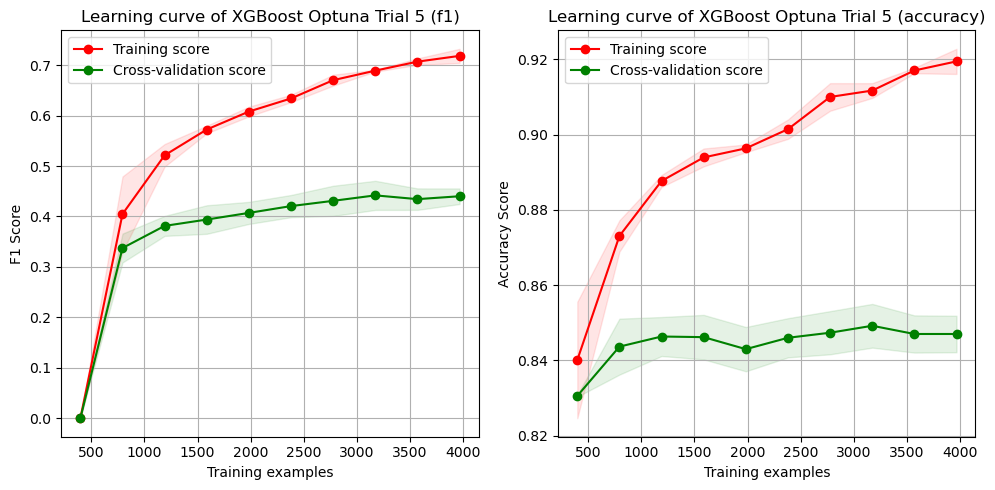

In [44]:
plot_learning_curve(XGBClassifier(**best_params5), X_train_transformed, y_train, "XGBoost Optuna Trial 5", cv=3, n_jobs=-1)

In [45]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001 , 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),
        'lambda': trial.suggest_float('lambda', 0.0, 1.0),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train, eval_set=[(X_valid_transformed, y_valid)], early_stopping_rounds=30, verbose=False)

    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score


sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params6 = study.best_params
print(best_params6)

[I 2023-07-21 17:24:21,290] A new study created in memory with name: no-name-63e85016-faef-41d5-8ec8-b7ab7fb396b2
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:24:21,831] Trial 0 finished with value: 0.45731707317073167 and parameters: {'n_estimators': 437, 'learning_rate': 0.2852635776165649, 'max_depth': 8, 'subsample': 0.7394633936788146, 'colsample_bytree': 0.40921304830970556, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'alpha': 0.8661761457749352, 'lambda': 0.6011150117432088}. Best is trial 0 with value: 0.45731707317073167.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor 

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:24:34,906] Trial 13 finished with value: 0.4568081991215227 and parameters: {'n_estimators': 997, 'learning_rate': 0.1956537251483068, 'max_depth': 5, 'subsample': 0.8997449754566207, 'colsample_bytree': 0.9895834469896453, 'gamma': 0.12774747405271558, 'min_child_weight': 3, 'alpha': 0.18036105118415416, 'lambda': 0.7072071119656391}. Best is trial 10 with value: 0.4992614475627769.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:24:35,473] Trial 14 finished with value: 0.443778110944

[I 2023-07-21 17:24:42,550] Trial 25 finished with value: 0.4508670520231214 and parameters: {'n_estimators': 188, 'learning_rate': 0.12964568707910776, 'max_depth': 4, 'subsample': 0.877818840879723, 'colsample_bytree': 0.8128357561552142, 'gamma': 1.2103042767397154, 'min_child_weight': 6, 'alpha': 0.08288066214855139, 'lambda': 0.08919359083121364}. Best is trial 17 with value: 0.5013927576601671.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:24:43,205] Trial 26 finished with value: 0.4871794871794871 and parameters: {'n_estimators': 176, 'learning_rate': 0.18405305547245304, 'max_depth': 6, 'subsample': 0.8404517250864116, 'colsample_bytree': 0.5707629673875393, 'gamma': 1.487833966321495, 'min_child_weight': 8, 'alpha': 0.22276913160035144, 'lambda': 0

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:24:50,940] Trial 38 finished with value: 0.4537313432835821 and parameters: {'n_estimators': 425, 'learning_rate': 0.27453913422445375, 'max_depth': 8, 'subsample': 0.8446738054376903, 'colsample_bytree': 0.8843321818853216, 'gamma': 0.46383440509409607, 'min_child_weight': 3, 'alpha': 0.06359680396044157, 'lambda': 0.2563142259843696}. Best is trial 33 with value: 0.5045871559633028.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:24:51,552] Trial 39 finished with value: 0.44992295839

[I 2023-07-21 17:24:58,349] Trial 50 finished with value: 0.46327683615819215 and parameters: {'n_estimators': 100, 'learning_rate': 0.2968231448084069, 'max_depth': 8, 'subsample': 0.8449514397491001, 'colsample_bytree': 0.9696078155014187, 'gamma': 1.612792554164521, 'min_child_weight': 7, 'alpha': 0.23491578659344622, 'lambda': 0.8786802333902552}. Best is trial 33 with value: 0.5045871559633028.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:24:59,064] Trial 51 finished with value: 0.4649776453055141 and parameters: {'n_estimators': 175, 'learning_rate': 0.1904461244945573, 'max_depth': 6, 'subsample': 0.8569569348200224, 'colsample_bytree': 0.5867661755303912, 'gamma': 1.868235603864239, 'min_child_weight': 9, 'alpha': 0.20438348797681477, 'lambda': 0.0

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:25:06,638] Trial 63 finished with value: 0.4414003044140031 and parameters: {'n_estimators': 205, 'learning_rate': 0.16188608116103337, 'max_depth': 6, 'subsample': 0.7925925602956146, 'colsample_bytree': 0.7210804002115219, 'gamma': 1.0939919163002259, 'min_child_weight': 2, 'alpha': 0.12262774313183324, 'lambda': 0.20911834788403236}. Best is trial 33 with value: 0.5045871559633028.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:25:07,333] Trial 64 finished with value: 0.46131386861

[I 2023-07-21 17:25:14,829] Trial 75 finished with value: 0.4640234948604993 and parameters: {'n_estimators': 463, 'learning_rate': 0.15590610553509013, 'max_depth': 4, 'subsample': 0.8138387492586222, 'colsample_bytree': 0.88010848024936, 'gamma': 0.681844591713784, 'min_child_weight': 5, 'alpha': 0.03283071472724419, 'lambda': 0.14789199973056094}. Best is trial 33 with value: 0.5045871559633028.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:25:15,571] Trial 76 finished with value: 0.43659711075441415 and parameters: {'n_estimators': 210, 'learning_rate': 0.13990050113737806, 'max_depth': 9, 'subsample': 0.8470909580166345, 'colsample_bytree': 0.931310721555409, 'gamma': 0.8847471098595971, 'min_child_weight': 3, 'alpha': 0.15459408450197604, 'lambda': 0.

C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:25:23,755] Trial 88 finished with value: 0.4811594202898551 and parameters: {'n_estimators': 275, 'learning_rate': 0.26854720233807283, 'max_depth': 9, 'subsample': 0.7445325236379668, 'colsample_bytree': 0.8372167031389224, 'gamma': 0.2838703160657334, 'min_child_weight': 7, 'alpha': 0.2442448159802241, 'lambda': 0.39881961653772613}. Best is trial 78 with value: 0.524300441826215.
C:\Users\duruh\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-07-21 17:25:24,462] Trial 89 finished with value: 0.4622356495468

{'n_estimators': 163, 'learning_rate': 0.16383280205713918, 'max_depth': 8, 'subsample': 0.8001893468545681, 'colsample_bytree': 0.7873026248803815, 'gamma': 0.28205678562941583, 'min_child_weight': 3, 'alpha': 0.20910816617980013, 'lambda': 0.23684308936638587}


In [46]:
clf = XGBClassifier(**best_params6)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 6", best_params6, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."


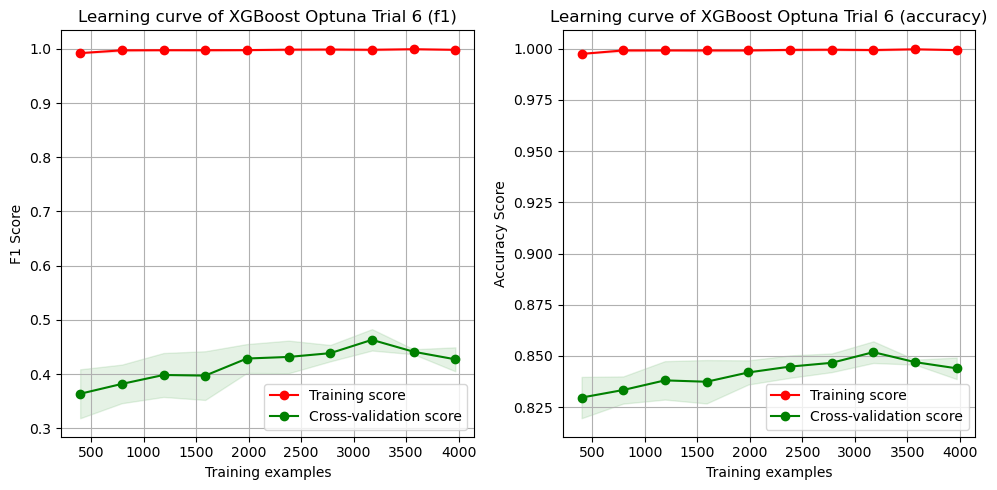

In [47]:
plot_learning_curve(XGBClassifier(**best_params6), X_train_transformed, y_train, "XGBoost Optuna Trial 6", cv=3, n_jobs=-1)

In [48]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # decreased upper limit
        'learning_rate': trial.suggest_float('learning_rate', 0.01 , 0.1),  # decreased upper limit
        'max_depth': trial.suggest_int('max_depth', 1, 6),  # decreased both limits
        'subsample': trial.suggest_float('subsample', 0.3, 0.7),  # decreased upper limit
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.7),  # decreased upper limit
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),  # increased both limits
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),
        'lambda': trial.suggest_float('lambda', 0.0, 1.0),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params7 = study.best_params
print(best_params7)

[I 2023-07-21 17:25:41,943] A new study created in memory with name: no-name-20b8de3c-c469-4af6-b345-420629bc73d9
[I 2023-07-21 17:25:42,784] Trial 0 finished with value: 0.4745269286754003 and parameters: {'n_estimators': 218, 'learning_rate': 0.09556428757689246, 'max_depth': 5, 'subsample': 0.5394633936788146, 'colsample_bytree': 0.36240745617697456, 'gamma': 0.7799726016810132, 'min_child_weight': 5, 'alpha': 0.8661761457749352, 'lambda': 0.6011150117432088}. Best is trial 0 with value: 0.4745269286754003.
[I 2023-07-21 17:25:44,185] Trial 1 finished with value: 0.37828947368421056 and parameters: {'n_estimators': 369, 'learning_rate': 0.011852604486622221, 'max_depth': 6, 'subsample': 0.6329770563201687, 'colsample_bytree': 0.38493564427131044, 'gamma': 0.9091248360355031, 'min_child_weight': 7, 'alpha': 0.3042422429595377, 'lambda': 0.5247564316322378}. Best is trial 0 with value: 0.4745269286754003.
[I 2023-07-21 17:25:44,979] Trial 2 finished with value: 0.44548286604361376 and

[I 2023-07-21 17:26:06,508] Trial 21 finished with value: 0.48071216617210677 and parameters: {'n_estimators': 388, 'learning_rate': 0.07587252485045928, 'max_depth': 5, 'subsample': 0.6935564705260873, 'colsample_bytree': 0.48142319808707934, 'gamma': 2.3559558047056965, 'min_child_weight': 9, 'alpha': 0.6802768777503201, 'lambda': 0.4050126123122588}. Best is trial 12 with value: 0.49147727272727276.
[I 2023-07-21 17:26:07,931] Trial 22 finished with value: 0.46176046176046176 and parameters: {'n_estimators': 373, 'learning_rate': 0.0797114403536264, 'max_depth': 6, 'subsample': 0.6383630770096759, 'colsample_bytree': 0.4658313612926887, 'gamma': 2.1409973048294844, 'min_child_weight': 11, 'alpha': 0.6899277216401561, 'lambda': 0.4344839085042094}. Best is trial 12 with value: 0.49147727272727276.
[I 2023-07-21 17:26:09,528] Trial 23 finished with value: 0.4624808575803982 and parameters: {'n_estimators': 458, 'learning_rate': 0.06658486226868972, 'max_depth': 5, 'subsample': 0.69971

[I 2023-07-21 17:26:32,684] Trial 42 finished with value: 0.44051446945337625 and parameters: {'n_estimators': 253, 'learning_rate': 0.09350467615821595, 'max_depth': 4, 'subsample': 0.5429749288558112, 'colsample_bytree': 0.3878069070062257, 'gamma': 3.20819995982317, 'min_child_weight': 12, 'alpha': 0.9141174147765933, 'lambda': 0.7784024130036126}. Best is trial 12 with value: 0.49147727272727276.
[I 2023-07-21 17:26:33,384] Trial 43 finished with value: 0.42790697674418604 and parameters: {'n_estimators': 217, 'learning_rate': 0.08393353213997792, 'max_depth': 2, 'subsample': 0.5175878544050803, 'colsample_bytree': 0.3666206925109342, 'gamma': 1.7666438990847984, 'min_child_weight': 13, 'alpha': 0.8858339784694634, 'lambda': 0.6459160036545379}. Best is trial 12 with value: 0.49147727272727276.
[I 2023-07-21 17:26:34,264] Trial 44 finished with value: 0.4761904761904762 and parameters: {'n_estimators': 234, 'learning_rate': 0.09604649227716944, 'max_depth': 4, 'subsample': 0.580588

[I 2023-07-21 17:26:57,055] Trial 63 finished with value: 0.44640234948604995 and parameters: {'n_estimators': 419, 'learning_rate': 0.07418656619848138, 'max_depth': 6, 'subsample': 0.534706882095569, 'colsample_bytree': 0.47583726427618117, 'gamma': 2.5750534186134058, 'min_child_weight': 9, 'alpha': 0.817757165705233, 'lambda': 0.43979308560827624}. Best is trial 12 with value: 0.49147727272727276.
[I 2023-07-21 17:26:58,438] Trial 64 finished with value: 0.4644412191582003 and parameters: {'n_estimators': 364, 'learning_rate': 0.07823106264577076, 'max_depth': 6, 'subsample': 0.574602507642801, 'colsample_bytree': 0.44255768823344993, 'gamma': 2.075503168662974, 'min_child_weight': 10, 'alpha': 0.9609897581020579, 'lambda': 0.588553593336269}. Best is trial 12 with value: 0.49147727272727276.
[I 2023-07-21 17:26:59,830] Trial 65 finished with value: 0.44897959183673464 and parameters: {'n_estimators': 388, 'learning_rate': 0.09001398301878488, 'max_depth': 6, 'subsample': 0.5558279

[I 2023-07-21 17:27:21,492] Trial 84 finished with value: 0.47267759562841527 and parameters: {'n_estimators': 295, 'learning_rate': 0.08044326497090507, 'max_depth': 5, 'subsample': 0.6538824829878094, 'colsample_bytree': 0.43672148611746076, 'gamma': 3.1864859777589256, 'min_child_weight': 7, 'alpha': 0.8315317671507836, 'lambda': 0.7223461195084652}. Best is trial 76 with value: 0.4992389649923896.
[I 2023-07-21 17:27:22,622] Trial 85 finished with value: 0.4261275272161742 and parameters: {'n_estimators': 282, 'learning_rate': 0.0917632269240846, 'max_depth': 5, 'subsample': 0.6931880522448545, 'colsample_bytree': 0.4466488926636241, 'gamma': 3.325770687910627, 'min_child_weight': 9, 'alpha': 0.6946108659390278, 'lambda': 0.5924306847893772}. Best is trial 76 with value: 0.4992389649923896.
[I 2023-07-21 17:27:23,759] Trial 86 finished with value: 0.4484304932735426 and parameters: {'n_estimators': 247, 'learning_rate': 0.07308801584250788, 'max_depth': 6, 'subsample': 0.6699495998

{'n_estimators': 241, 'learning_rate': 0.07692239584932475, 'max_depth': 6, 'subsample': 0.6671377206529872, 'colsample_bytree': 0.41333178890255395, 'gamma': 3.053888541761225, 'min_child_weight': 8, 'alpha': 0.7892504351216492, 'lambda': 0.6747950957710189}


In [49]:
clf = XGBClassifier(**best_params7)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 7", best_params7, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."
6,XGBoost Optuna Trial 7,0.860165,155,79,2041,278,0.662393,0.357968,0.660352,0.537419,0.464768,0.394201,"{'n_estimators': 241, 'learning_rate': 0.07692..."


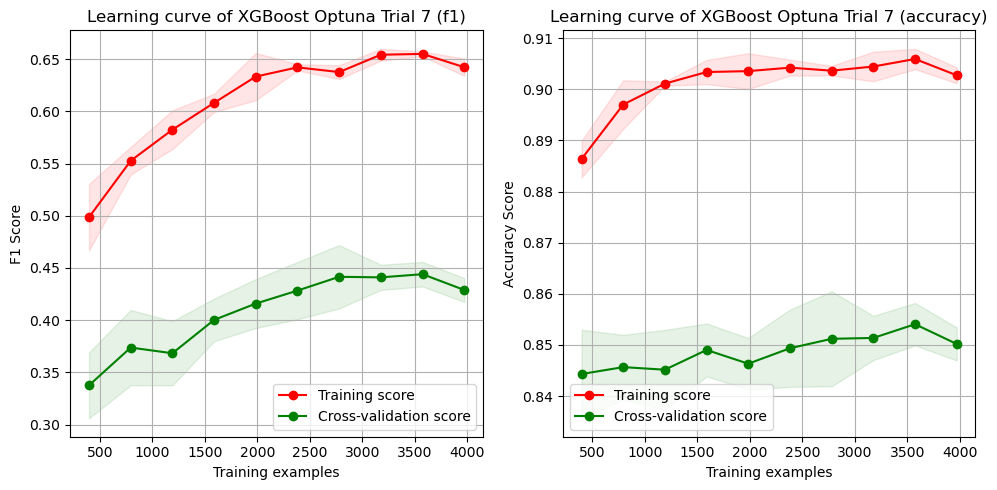

In [50]:
plot_learning_curve(XGBClassifier(**best_params7), X_train_transformed, y_train, "XGBoost Optuna Trial 7", cv=3, n_jobs=-1)

In [51]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01 , 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 4),
        'subsample': trial.suggest_float('subsample', 0.2, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.6),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 25),
        'alpha': trial.suggest_float('alpha', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.5, 1.0),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params8 = study.best_params
print(best_params8)

[I 2023-07-21 17:27:45,045] A new study created in memory with name: no-name-b5db50a9-80fb-4707-9d2c-81af3917a702
[I 2023-07-21 17:27:45,664] Trial 0 finished with value: 0.450920245398773 and parameters: {'n_estimators': 144, 'learning_rate': 0.09556428757689246, 'max_depth': 3, 'subsample': 0.4394633936788146, 'colsample_bytree': 0.2624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 10, 'alpha': 0.9330880728874675, 'lambda': 0.8005575058716043}. Best is trial 0 with value: 0.450920245398773.
[I 2023-07-21 17:27:46,552] Trial 1 finished with value: 0.21052631578947367 and parameters: {'n_estimators': 227, 'learning_rate': 0.011852604486622221, 'max_depth': 4, 'subsample': 0.5329770563201687, 'colsample_bytree': 0.28493564427131046, 'gamma': 0.9091248360355031, 'min_child_weight': 12, 'alpha': 0.6521211214797689, 'lambda': 0.762378215816119}. Best is trial 0 with value: 0.450920245398773.
[I 2023-07-21 17:27:47,175] Trial 2 finished with value: 0.3691756272401434 and par

[I 2023-07-21 17:27:59,392] Trial 21 finished with value: 0.4577259475218658 and parameters: {'n_estimators': 268, 'learning_rate': 0.09032950333963807, 'max_depth': 4, 'subsample': 0.4054549617551995, 'colsample_bytree': 0.5893716564113967, 'gamma': 4.164352629697697, 'min_child_weight': 14, 'alpha': 0.926064276591355, 'lambda': 0.5461400247580652}. Best is trial 20 with value: 0.471976401179941.
[I 2023-07-21 17:28:00,345] Trial 22 finished with value: 0.40604026845637586 and parameters: {'n_estimators': 294, 'learning_rate': 0.08563761301154202, 'max_depth': 4, 'subsample': 0.3949080050795707, 'colsample_bytree': 0.5973976858440313, 'gamma': 4.255066085194731, 'min_child_weight': 15, 'alpha': 0.9219708727460092, 'lambda': 0.5471395627523096}. Best is trial 20 with value: 0.471976401179941.
[I 2023-07-21 17:28:01,190] Trial 23 finished with value: 0.4663536776212832 and parameters: {'n_estimators': 260, 'learning_rate': 0.0911034372471152, 'max_depth': 4, 'subsample': 0.3420108366414

[I 2023-07-21 17:28:16,816] Trial 42 finished with value: 0.4617647058823529 and parameters: {'n_estimators': 224, 'learning_rate': 0.08910910348323067, 'max_depth': 4, 'subsample': 0.3263957942284798, 'colsample_bytree': 0.5683530955963355, 'gamma': 4.373569941029032, 'min_child_weight': 16, 'alpha': 0.8860084328920588, 'lambda': 0.574285015914205}. Best is trial 37 with value: 0.47860538827258325.
[I 2023-07-21 17:28:17,584] Trial 43 finished with value: 0.466867469879518 and parameters: {'n_estimators': 220, 'learning_rate': 0.08950604426993407, 'max_depth': 4, 'subsample': 0.30152505223012704, 'colsample_bytree': 0.5656841684059732, 'gamma': 4.251161231840465, 'min_child_weight': 13, 'alpha': 0.9543570277354447, 'lambda': 0.5296649137863598}. Best is trial 37 with value: 0.47860538827258325.
[I 2023-07-21 17:28:18,332] Trial 44 finished with value: 0.425531914893617 and parameters: {'n_estimators': 221, 'learning_rate': 0.08896187603703372, 'max_depth': 4, 'subsample': 0.2931648182

[I 2023-07-21 17:28:32,782] Trial 63 finished with value: 0.4361370716510904 and parameters: {'n_estimators': 238, 'learning_rate': 0.0653016613053458, 'max_depth': 2, 'subsample': 0.30007825446515296, 'colsample_bytree': 0.5501520885725338, 'gamma': 3.8156390102142566, 'min_child_weight': 23, 'alpha': 0.9576400179164698, 'lambda': 0.5432081701176414}. Best is trial 55 with value: 0.4838709677419355.
[I 2023-07-21 17:28:33,639] Trial 64 finished with value: 0.445095168374817 and parameters: {'n_estimators': 283, 'learning_rate': 0.07641332225108226, 'max_depth': 3, 'subsample': 0.4138167047148002, 'colsample_bytree': 0.5852933808306346, 'gamma': 3.2036320533509075, 'min_child_weight': 24, 'alpha': 0.9995212827591996, 'lambda': 0.5134338478551158}. Best is trial 55 with value: 0.4838709677419355.
[I 2023-07-21 17:28:34,450] Trial 65 finished with value: 0.4441132637853949 and parameters: {'n_estimators': 274, 'learning_rate': 0.07976234866137713, 'max_depth': 3, 'subsample': 0.322399939

[I 2023-07-21 17:28:49,568] Trial 84 finished with value: 0.39874411302982726 and parameters: {'n_estimators': 233, 'learning_rate': 0.09807866512594238, 'max_depth': 3, 'subsample': 0.3434973069968117, 'colsample_bytree': 0.590581677971848, 'gamma': 3.962960792661157, 'min_child_weight': 13, 'alpha': 0.9705607892574988, 'lambda': 0.5650811662813991}. Best is trial 55 with value: 0.4838709677419355.
[I 2023-07-21 17:28:50,485] Trial 85 finished with value: 0.45535714285714285 and parameters: {'n_estimators': 278, 'learning_rate': 0.09056941847304019, 'max_depth': 3, 'subsample': 0.3323414199408227, 'colsample_bytree': 0.5469689011923818, 'gamma': 4.322375447941664, 'min_child_weight': 10, 'alpha': 0.9235076130040087, 'lambda': 0.5818279237081628}. Best is trial 55 with value: 0.4838709677419355.
[I 2023-07-21 17:28:51,417] Trial 86 finished with value: 0.4283604135893649 and parameters: {'n_estimators': 242, 'learning_rate': 0.09457552782896218, 'max_depth': 4, 'subsample': 0.356638075

{'n_estimators': 290, 'learning_rate': 0.07109617463542853, 'max_depth': 3, 'subsample': 0.32985262674182514, 'colsample_bytree': 0.5492160725442814, 'gamma': 4.360228531928779, 'min_child_weight': 21, 'alpha': 0.90703270993174, 'lambda': 0.5745774767219222}


In [52]:
clf = XGBClassifier(**best_params8)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 8", best_params8, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."
6,XGBoost Optuna Trial 7,0.860165,155,79,2041,278,0.662393,0.357968,0.660352,0.537419,0.464768,0.394201,"{'n_estimators': 241, 'learning_rate': 0.07692..."
7,XGBoost Optuna Trial 8,0.857814,147,77,2043,286,0.656250,0.339492,0.651586,0.552280,0.447489,0.375767,"{'n_estimators': 290, 'learning_rate': 0.07109..."


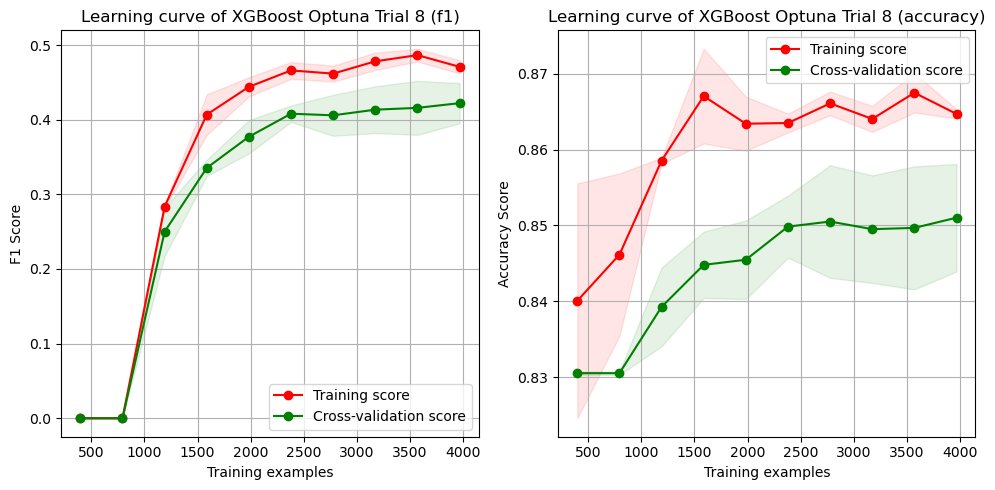

In [53]:
plot_learning_curve(XGBClassifier(**best_params8), X_train_transformed, y_train, "XGBoost Optuna Trial 8", cv=3, n_jobs=-1)

In [54]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),  # decreased upper limit
        'learning_rate': trial.suggest_float('learning_rate', 0.001 , 0.1),  # decreased lower limit
        'max_depth': trial.suggest_int('max_depth', 1, 3),  # decreased upper limit
        'subsample': trial.suggest_float('subsample', 0.2, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.6),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 25),
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),  # widened range
        'lambda': trial.suggest_float('lambda', 0.0, 2.0),  # widened range
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params9 = study.best_params
print(best_params9)

[I 2023-07-21 17:29:06,745] A new study created in memory with name: no-name-e1fd60b0-74d9-4c1d-89d1-0d0a1ff201ef
[I 2023-07-21 17:29:07,182] Trial 0 finished with value: 0.36363636363636365 and parameters: {'n_estimators': 81, 'learning_rate': 0.0951207163345817, 'max_depth': 3, 'subsample': 0.4394633936788146, 'colsample_bytree': 0.2624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 10, 'alpha': 0.8661761457749352, 'lambda': 1.2022300234864176}. Best is trial 0 with value: 0.36363636363636365.
[I 2023-07-21 17:29:07,767] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 145, 'learning_rate': 0.0030378649352844423, 'max_depth': 3, 'subsample': 0.5329770563201687, 'colsample_bytree': 0.28493564427131046, 'gamma': 0.9091248360355031, 'min_child_weight': 12, 'alpha': 0.3042422429595377, 'lambda': 1.0495128632644757}. Best is trial 0 with value: 0.36363636363636365.
[I 2023-07-21 17:29:08,231] Trial 2 finished with value: 0.1271186440677966 and parameters: {

[I 2023-07-21 17:29:19,441] Trial 21 finished with value: 0.41949778434268836 and parameters: {'n_estimators': 176, 'learning_rate': 0.07680218567693939, 'max_depth': 2, 'subsample': 0.5958199786205801, 'colsample_bytree': 0.43424099736829197, 'gamma': 1.8879361377738675, 'min_child_weight': 14, 'alpha': 0.5052288378246792, 'lambda': 0.02510039873584053}. Best is trial 12 with value: 0.4660766961651917.
[I 2023-07-21 17:29:20,118] Trial 22 finished with value: 0.40634920634920635 and parameters: {'n_estimators': 187, 'learning_rate': 0.08434830669152751, 'max_depth': 2, 'subsample': 0.5762337881832208, 'colsample_bytree': 0.45726031829352204, 'gamma': 1.712667171375609, 'min_child_weight': 15, 'alpha': 0.49932966653351785, 'lambda': 0.7305439072861403}. Best is trial 12 with value: 0.4660766961651917.
[I 2023-07-21 17:29:20,847] Trial 23 finished with value: 0.481203007518797 and parameters: {'n_estimators': 183, 'learning_rate': 0.07872471543701047, 'max_depth': 3, 'subsample': 0.5997

[I 2023-07-21 17:29:33,606] Trial 42 finished with value: 0.4603886397608371 and parameters: {'n_estimators': 192, 'learning_rate': 0.08321867161838228, 'max_depth': 3, 'subsample': 0.5986777373594426, 'colsample_bytree': 0.40375986377267026, 'gamma': 0.7139312622543263, 'min_child_weight': 16, 'alpha': 0.5399005334215956, 'lambda': 0.9863753274321935}. Best is trial 23 with value: 0.481203007518797.
[I 2023-07-21 17:29:34,294] Trial 43 finished with value: 0.4310077519379845 and parameters: {'n_estimators': 180, 'learning_rate': 0.09485847676984362, 'max_depth': 3, 'subsample': 0.5743581721118004, 'colsample_bytree': 0.20496708122962864, 'gamma': 0.9572029565915336, 'min_child_weight': 14, 'alpha': 0.6144304517694994, 'lambda': 1.2153885822574058}. Best is trial 23 with value: 0.481203007518797.
[I 2023-07-21 17:29:35,028] Trial 44 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 194, 'learning_rate': 0.08308469620308324, 'max_depth': 3, 'subsample': 0.55296608

[I 2023-07-21 17:29:47,909] Trial 63 finished with value: 0.45852187028657615 and parameters: {'n_estimators': 194, 'learning_rate': 0.076970024807357, 'max_depth': 3, 'subsample': 0.5345975843383738, 'colsample_bytree': 0.3778552384763183, 'gamma': 1.153240700782309, 'min_child_weight': 15, 'alpha': 0.5214952133009734, 'lambda': 1.2031953090252057}. Best is trial 57 with value: 0.48901903367496335.
[I 2023-07-21 17:29:48,664] Trial 64 finished with value: 0.4473684210526316 and parameters: {'n_estimators': 200, 'learning_rate': 0.09104046687241815, 'max_depth': 3, 'subsample': 0.5447406948740587, 'colsample_bytree': 0.4222641087672189, 'gamma': 2.256243725683018, 'min_child_weight': 11, 'alpha': 0.6046459370763562, 'lambda': 1.0532982700745424}. Best is trial 57 with value: 0.48901903367496335.
[I 2023-07-21 17:29:49,369] Trial 65 finished with value: 0.4608294930875576 and parameters: {'n_estimators': 172, 'learning_rate': 0.08319334488003641, 'max_depth': 3, 'subsample': 0.582160583

[I 2023-07-21 17:30:03,080] Trial 84 finished with value: 0.4546850998463902 and parameters: {'n_estimators': 183, 'learning_rate': 0.09159534687923218, 'max_depth': 3, 'subsample': 0.5604654141224775, 'colsample_bytree': 0.41376640144942123, 'gamma': 1.8763517775940937, 'min_child_weight': 11, 'alpha': 0.6661165794413068, 'lambda': 1.5487899677995773}. Best is trial 57 with value: 0.48901903367496335.
[I 2023-07-21 17:30:03,755] Trial 85 finished with value: 0.4403973509933775 and parameters: {'n_estimators': 159, 'learning_rate': 0.07961716306843762, 'max_depth': 3, 'subsample': 0.5668945927782534, 'colsample_bytree': 0.38335554379299125, 'gamma': 2.0636264312674677, 'min_child_weight': 13, 'alpha': 0.8553775853440818, 'lambda': 1.3340889941322862}. Best is trial 57 with value: 0.48901903367496335.
[I 2023-07-21 17:30:04,509] Trial 86 finished with value: 0.4610778443113772 and parameters: {'n_estimators': 194, 'learning_rate': 0.08576908078752488, 'max_depth': 3, 'subsample': 0.5891

{'n_estimators': 185, 'learning_rate': 0.09675046834455475, 'max_depth': 3, 'subsample': 0.5821948342893303, 'colsample_bytree': 0.41426140696772373, 'gamma': 1.9046317304693132, 'min_child_weight': 11, 'alpha': 0.6436919890393035, 'lambda': 1.3333412973329002}


In [55]:
clf = XGBClassifier(**best_params9)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 9", best_params9, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."
6,XGBoost Optuna Trial 7,0.860165,155,79,2041,278,0.662393,0.357968,0.660352,0.537419,0.464768,0.394201,"{'n_estimators': 241, 'learning_rate': 0.07692..."
7,XGBoost Optuna Trial 8,0.857814,147,77,2043,286,0.656250,0.339492,0.651586,0.552280,0.447489,0.375767,"{'n_estimators': 290, 'learning_rate': 0.07109..."
8,XGBoost Optuna Trial 9,0.860948,152,74,2046,281,0.672566,0.351039,0.658067,0.551865,0.461305,0.388151,"{'n_estimators': 185, 'learning_rate': 0.09675..."


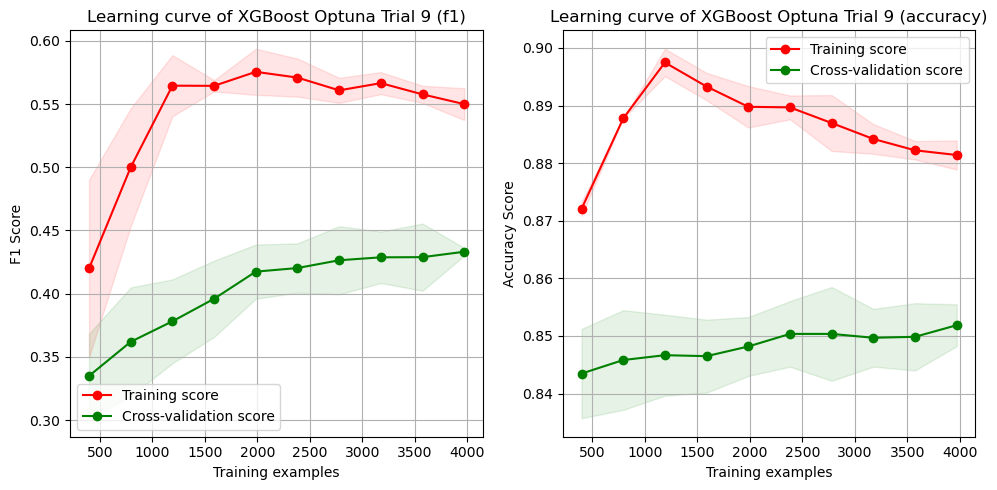

In [56]:
plot_learning_curve(XGBClassifier(**best_params9), X_train_transformed, y_train, "XGBoost Optuna Trial 9", cv=3, n_jobs=-1)

In [57]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 150),  # decreased upper limit
        'learning_rate': trial.suggest_float('learning_rate', 0.01 , 0.05),  # decreased upper limit
        'max_depth': trial.suggest_int('max_depth', 1, 3),
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),  # narrowed range
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),  # narrowed range
        'gamma': trial.suggest_float('gamma', 0, 2),  # decreased upper limit
        'min_child_weight': trial.suggest_int('min_child_weight', 15, 25),  # increased lower limit
        'alpha': trial.suggest_float('alpha', 0.5, 1.0),  # increased lower limit
        'lambda': trial.suggest_float('lambda', 1.0, 2.0),  # increased lower limit
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params10 = study.best_params
print(best_params10)

[I 2023-07-21 17:30:18,176] A new study created in memory with name: no-name-669f92bd-1952-4b18-8e01-68aa9691e3c7
[I 2023-07-21 17:30:18,594] Trial 0 finished with value: 0.25426944971537 and parameters: {'n_estimators': 62, 'learning_rate': 0.04802857225639665, 'max_depth': 3, 'subsample': 0.5197316968394073, 'colsample_bytree': 0.43120372808848734, 'gamma': 0.3119890406724053, 'min_child_weight': 15, 'alpha': 0.9330880728874675, 'lambda': 1.6011150117432087}. Best is trial 0 with value: 0.25426944971537.
[I 2023-07-21 17:30:19,138] Trial 1 finished with value: 0.10970464135021098 and parameters: {'n_estimators': 109, 'learning_rate': 0.010823379771832098, 'max_depth': 3, 'subsample': 0.5664885281600843, 'colsample_bytree': 0.4424678221356552, 'gamma': 0.36364993441420124, 'min_child_weight': 17, 'alpha': 0.6521211214797689, 'lambda': 1.524756431632238}. Best is trial 0 with value: 0.25426944971537.
[I 2023-07-21 17:30:19,580] Trial 2 finished with value: 0.11134903640256959 and param

[I 2023-07-21 17:30:29,931] Trial 21 finished with value: 0.4155038759689922 and parameters: {'n_estimators': 149, 'learning_rate': 0.04945488933028798, 'max_depth': 3, 'subsample': 0.5859585253711121, 'colsample_bytree': 0.4859949117832711, 'gamma': 0.5329580298113967, 'min_child_weight': 16, 'alpha': 0.8081166913776813, 'lambda': 1.7745400994206506}. Best is trial 15 with value: 0.4563106796116505.
[I 2023-07-21 17:30:30,564] Trial 22 finished with value: 0.38142620232172475 and parameters: {'n_estimators': 135, 'learning_rate': 0.045071749157892166, 'max_depth': 3, 'subsample': 0.5988668596348509, 'colsample_bytree': 0.5082370796733521, 'gamma': 0.8519949911682917, 'min_child_weight': 16, 'alpha': 0.844963860820078, 'lambda': 1.8931105997216127}. Best is trial 15 with value: 0.4563106796116505.
[I 2023-07-21 17:30:31,206] Trial 23 finished with value: 0.3852327447833066 and parameters: {'n_estimators': 149, 'learning_rate': 0.046045972109828956, 'max_depth': 3, 'subsample': 0.403662

[I 2023-07-21 17:30:42,637] Trial 42 finished with value: 0.45625 and parameters: {'n_estimators': 150, 'learning_rate': 0.047337494614852496, 'max_depth': 3, 'subsample': 0.5925676269585831, 'colsample_bytree': 0.5066529427161413, 'gamma': 0.822749337996912, 'min_child_weight': 17, 'alpha': 0.8465784789476639, 'lambda': 1.8662231143493997}. Best is trial 15 with value: 0.4563106796116505.
[I 2023-07-21 17:30:43,270] Trial 43 finished with value: 0.35947712418300654 and parameters: {'n_estimators': 135, 'learning_rate': 0.04133457209166091, 'max_depth': 3, 'subsample': 0.5998510941949075, 'colsample_bytree': 0.5108061257761051, 'gamma': 0.8100101278258071, 'min_child_weight': 24, 'alpha': 0.8805884273748269, 'lambda': 1.951883485761851}. Best is trial 15 with value: 0.4563106796116505.
[I 2023-07-21 17:30:43,918] Trial 44 finished with value: 0.396039603960396 and parameters: {'n_estimators': 142, 'learning_rate': 0.04752058753177606, 'max_depth': 3, 'subsample': 0.5778914827723081, 'c

[I 2023-07-21 17:30:55,874] Trial 63 finished with value: 0.4228934817170111 and parameters: {'n_estimators': 146, 'learning_rate': 0.04608849289904758, 'max_depth': 3, 'subsample': 0.5921181000283064, 'colsample_bytree': 0.5507664063937451, 'gamma': 1.0103425998001208, 'min_child_weight': 16, 'alpha': 0.8965208270337884, 'lambda': 1.904584736387803}. Best is trial 15 with value: 0.4563106796116505.
[I 2023-07-21 17:30:56,512] Trial 64 finished with value: 0.40257648953301123 and parameters: {'n_estimators': 136, 'learning_rate': 0.04664416950715964, 'max_depth': 3, 'subsample': 0.5818013497836387, 'colsample_bytree': 0.5343565144550477, 'gamma': 1.191342910256392, 'min_child_weight': 15, 'alpha': 0.969254120572058, 'lambda': 1.9392283447718968}. Best is trial 15 with value: 0.4563106796116505.
[I 2023-07-21 17:30:57,170] Trial 65 finished with value: 0.47251114413075784 and parameters: {'n_estimators': 145, 'learning_rate': 0.04888941800653441, 'max_depth': 3, 'subsample': 0.571655996

[I 2023-07-21 17:31:09,570] Trial 84 finished with value: 0.3874015748031496 and parameters: {'n_estimators': 137, 'learning_rate': 0.047696493800199205, 'max_depth': 3, 'subsample': 0.5719793407938326, 'colsample_bytree': 0.5710938069187756, 'gamma': 1.0791074874088193, 'min_child_weight': 21, 'alpha': 0.9318100867925709, 'lambda': 1.9968225558892199}. Best is trial 65 with value: 0.47251114413075784.
[I 2023-07-21 17:31:10,232] Trial 85 finished with value: 0.4361873990306947 and parameters: {'n_estimators': 147, 'learning_rate': 0.0459745541232714, 'max_depth': 3, 'subsample': 0.5697995367495645, 'colsample_bytree': 0.5299027447943092, 'gamma': 0.9394791054847376, 'min_child_weight': 19, 'alpha': 0.973475152943319, 'lambda': 1.8583662128515854}. Best is trial 65 with value: 0.47251114413075784.
[I 2023-07-21 17:31:10,891] Trial 86 finished with value: 0.4083601286173633 and parameters: {'n_estimators': 148, 'learning_rate': 0.046203602351907264, 'max_depth': 3, 'subsample': 0.579172

{'n_estimators': 145, 'learning_rate': 0.04888941800653441, 'max_depth': 3, 'subsample': 0.5716559968405504, 'colsample_bytree': 0.5371134327882824, 'gamma': 0.8967388925599992, 'min_child_weight': 16, 'alpha': 0.9677851045435117, 'lambda': 1.9954469378082063}


In [58]:
clf = XGBClassifier(**best_params10)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 10", best_params10, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."
6,XGBoost Optuna Trial 7,0.860165,155,79,2041,278,0.662393,0.357968,0.660352,0.537419,0.464768,0.394201,"{'n_estimators': 241, 'learning_rate': 0.07692..."
7,XGBoost Optuna Trial 8,0.857814,147,77,2043,286,0.656250,0.339492,0.651586,0.552280,0.447489,0.375767,"{'n_estimators': 290, 'learning_rate': 0.07109..."
8,XGBoost Optuna Trial 9,0.860948,152,74,2046,281,0.672566,0.351039,0.658067,0.551865,0.461305,0.388151,"{'n_estimators': 185, 'learning_rate': 0.09675..."
9,XGBoost Optuna Trial 10,0.858989,134,61,2059,299,0.687179,0.309469,0.640348,0.542024,0.426752,0.347691,"{'n_estimators': 145, 'learning_rate': 0.04888..."


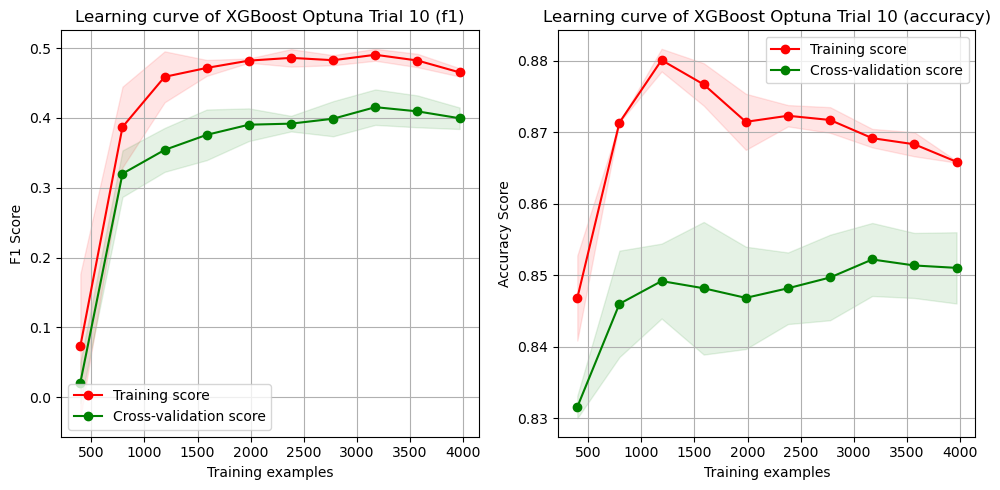

In [59]:
plot_learning_curve(XGBClassifier(**best_params10), X_train_transformed, y_train, "XGBoost Optuna Trial 10", cv=3, n_jobs=-1)

In [60]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 100),  # decreased upper limit
        'learning_rate': trial.suggest_float('learning_rate', 0.005 , 0.03),  # decreased both limits
        'max_depth': trial.suggest_int('max_depth', 1, 2),  # decreased upper limit
        'subsample': trial.suggest_float('subsample', 0.2, 0.5),  # decreased upper limit
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.5),  # decreased upper limit
        'gamma': trial.suggest_float('gamma', 2, 5),  # increased both limits
        'min_child_weight': trial.suggest_int('min_child_weight', 20, 30),  # increased lower limit
        'alpha': trial.suggest_float('alpha', 1.0, 2.0),  # increased both limits
        'lambda': trial.suggest_float('lambda', 2.0, 3.0),  # increased both limits
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params11 = study.best_params
print(best_params11)

[I 2023-07-21 17:31:22,908] A new study created in memory with name: no-name-178e42fc-11ca-4fa7-b2d8-f5f82b80a759
[I 2023-07-21 17:31:23,273] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 40, 'learning_rate': 0.028767857660247902, 'max_depth': 2, 'subsample': 0.379597545259111, 'colsample_bytree': 0.24680559213273096, 'gamma': 2.467983561008608, 'min_child_weight': 20, 'alpha': 1.866176145774935, 'lambda': 2.6011150117432087}. Best is trial 0 with value: 0.0.
[I 2023-07-21 17:31:23,710] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 72, 'learning_rate': 0.005514612357395061, 'max_depth': 2, 'subsample': 0.4497327922401265, 'colsample_bytree': 0.26370173320348284, 'gamma': 2.5454749016213016, 'min_child_weight': 22, 'alpha': 1.3042422429595377, 'lambda': 2.524756431632238}. Best is trial 0 with value: 0.0.
[I 2023-07-21 17:31:24,111] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 46, 'learning_rate': 0.012280728504951047, 'max_de

[I 2023-07-21 17:31:33,407] Trial 22 finished with value: 0.13513513513513511 and parameters: {'n_estimators': 78, 'learning_rate': 0.024793731612560974, 'max_depth': 2, 'subsample': 0.468756396377213, 'colsample_bytree': 0.4073286097028613, 'gamma': 2.1283396736778077, 'min_child_weight': 21, 'alpha': 1.4710266765720952, 'lambda': 2.6717614945595245}. Best is trial 13 with value: 0.1437125748502994.
[I 2023-07-21 17:31:33,909] Trial 23 finished with value: 0.0846325167037862 and parameters: {'n_estimators': 80, 'learning_rate': 0.024611291624288052, 'max_depth': 2, 'subsample': 0.4262087637166796, 'colsample_bytree': 0.40874748876434985, 'gamma': 2.102232666834759, 'min_child_weight': 21, 'alpha': 1.4611767557695123, 'lambda': 2.718244656287355}. Best is trial 13 with value: 0.1437125748502994.
[I 2023-07-21 17:31:34,380] Trial 24 finished with value: 0.08163265306122448 and parameters: {'n_estimators': 57, 'learning_rate': 0.026845847886252064, 'max_depth': 2, 'subsample': 0.46629470

[I 2023-07-21 17:31:43,837] Trial 43 finished with value: 0.12595419847328246 and parameters: {'n_estimators': 87, 'learning_rate': 0.025345181160923935, 'max_depth': 2, 'subsample': 0.3924227277164234, 'colsample_bytree': 0.46430538231401475, 'gamma': 2.19271721148873, 'min_child_weight': 26, 'alpha': 1.6569347521383395, 'lambda': 2.497330359399049}. Best is trial 31 with value: 0.2450592885375494.
[I 2023-07-21 17:31:44,370] Trial 44 finished with value: 0.1996086105675147 and parameters: {'n_estimators': 96, 'learning_rate': 0.026938756408609706, 'max_depth': 2, 'subsample': 0.44799450088608833, 'colsample_bytree': 0.48025112369494893, 'gamma': 2.2096350186746836, 'min_child_weight': 25, 'alpha': 1.5885775814563279, 'lambda': 2.558148239993771}. Best is trial 31 with value: 0.2450592885375494.
[I 2023-07-21 17:31:44,890] Trial 45 finished with value: 0.2389210019267823 and parameters: {'n_estimators': 96, 'learning_rate': 0.025980841714077784, 'max_depth': 2, 'subsample': 0.41099290

[I 2023-07-21 17:31:54,609] Trial 64 finished with value: 0.11691022964509394 and parameters: {'n_estimators': 94, 'learning_rate': 0.024734127189060495, 'max_depth': 2, 'subsample': 0.4659192183089336, 'colsample_bytree': 0.4620966988303976, 'gamma': 2.2124566159658476, 'min_child_weight': 27, 'alpha': 1.6821060982234401, 'lambda': 2.454685674748129}. Best is trial 31 with value: 0.2450592885375494.
[I 2023-07-21 17:31:55,132] Trial 65 finished with value: 0.17796610169491525 and parameters: {'n_estimators': 97, 'learning_rate': 0.02860215558262138, 'max_depth': 2, 'subsample': 0.48598338926186624, 'colsample_bytree': 0.4699831614008506, 'gamma': 2.4290106907561935, 'min_child_weight': 28, 'alpha': 1.5924547762560946, 'lambda': 2.382444818358008}. Best is trial 31 with value: 0.2450592885375494.
[I 2023-07-21 17:31:55,636] Trial 66 finished with value: 0.14315789473684212 and parameters: {'n_estimators': 80, 'learning_rate': 0.026583807111566403, 'max_depth': 2, 'subsample': 0.4193459

[I 2023-07-21 17:32:05,215] Trial 85 finished with value: 0.2068965517241379 and parameters: {'n_estimators': 80, 'learning_rate': 0.029443957888973228, 'max_depth': 2, 'subsample': 0.4283650087878953, 'colsample_bytree': 0.4820923725093877, 'gamma': 2.0659179269975003, 'min_child_weight': 22, 'alpha': 1.4116512403511103, 'lambda': 2.4987883965867117}. Best is trial 68 with value: 0.24535315985130113.
[I 2023-07-21 17:32:05,711] Trial 86 finished with value: 0.14457831325301204 and parameters: {'n_estimators': 80, 'learning_rate': 0.029370620194259216, 'max_depth': 2, 'subsample': 0.43388652122900656, 'colsample_bytree': 0.47915240043721724, 'gamma': 2.054918774678768, 'min_child_weight': 22, 'alpha': 1.3175743255587862, 'lambda': 2.4824604863484137}. Best is trial 68 with value: 0.24535315985130113.
[I 2023-07-21 17:32:06,254] Trial 87 finished with value: 0.11637931034482757 and parameters: {'n_estimators': 72, 'learning_rate': 0.028181471311949265, 'max_depth': 2, 'subsample': 0.427

{'n_estimators': 93, 'learning_rate': 0.029386298432316056, 'max_depth': 2, 'subsample': 0.4458318126574901, 'colsample_bytree': 0.4807782039954027, 'gamma': 2.2839144258663024, 'min_child_weight': 24, 'alpha': 1.5171204954075486, 'lambda': 2.4294232346064866}


In [61]:
clf = XGBClassifier(**best_params11)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 11", best_params11, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."
6,XGBoost Optuna Trial 7,0.860165,155,79,2041,278,0.662393,0.357968,0.660352,0.537419,0.464768,0.394201,"{'n_estimators': 241, 'learning_rate': 0.07692..."
7,XGBoost Optuna Trial 8,0.857814,147,77,2043,286,0.656250,0.339492,0.651586,0.552280,0.447489,0.375767,"{'n_estimators': 290, 'learning_rate': 0.07109..."
8,XGBoost Optuna Trial 9,0.860948,152,74,2046,281,0.672566,0.351039,0.658067,0.551865,0.461305,0.388151,"{'n_estimators': 185, 'learning_rate': 0.09675..."
9,XGBoost Optuna Trial 10,0.858989,134,61,2059,299,0.687179,0.309469,0.640348,0.542024,0.426752,0.347691,"{'n_estimators': 145, 'learning_rate': 0.04888..."


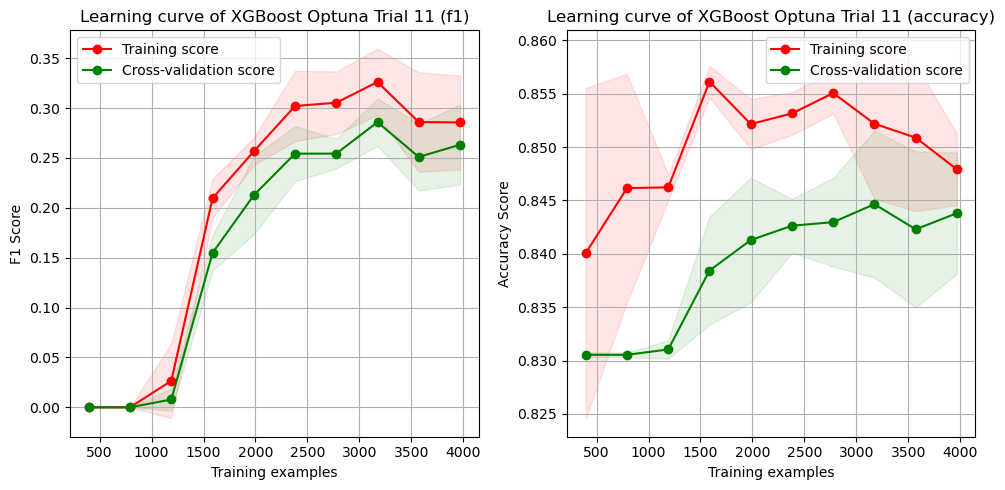

In [62]:
plot_learning_curve(XGBClassifier(**best_params11), X_train_transformed, y_train, "XGBoost Optuna Trial 11", cv=3, n_jobs=-1)

In [63]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200), # starting from a higher number might help
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2), # restricting upper limit to prevent overfitting
        'max_depth': trial.suggest_int('max_depth', 3, 8), # increasing the depth, but not too much to prevent overfitting
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), # no change
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0), # no change
        'gamma': trial.suggest_float('gamma', 0, 3), # decreasing upper limit, but still allowing model to control complexity
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20), # widened the range
        'eval_metric': 'logloss' # no change
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params12 = study.best_params
print(best_params12)

[I 2023-07-21 17:32:14,875] A new study created in memory with name: no-name-fce3f36f-9fa5-49ce-bedb-66793cf5f089
[I 2023-07-21 17:32:17,068] Trial 0 finished with value: 0.45769764216366154 and parameters: {'n_estimators': 574, 'learning_rate': 0.19063571821788408, 'max_depth': 7, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.40921304830970556, 'gamma': 0.46798356100860794, 'min_child_weight': 5}. Best is trial 0 with value: 0.45769764216366154.
[I 2023-07-21 17:32:20,813] Trial 1 finished with value: 0.45303867403314924 and parameters: {'n_estimators': 1067, 'learning_rate': 0.12421185223120967, 'max_depth': 7, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.978936896513396, 'gamma': 2.497327922401265, 'min_child_weight': 8}. Best is trial 0 with value: 0.45769764216366154.
[I 2023-07-21 17:32:22,050] Trial 2 finished with value: 0.4454545454545455 and parameters: {'n_estimators': 382, 'learning_rate': 0.044846856872152424, 'max_depth': 4, 'subsample': 0.7623782158161

[I 2023-07-21 17:33:11,170] Trial 24 finished with value: 0.48360655737704916 and parameters: {'n_estimators': 774, 'learning_rate': 0.09234376687207073, 'max_depth': 5, 'subsample': 0.6482260870792964, 'colsample_bytree': 0.911906148589483, 'gamma': 0.6760558951880735, 'min_child_weight': 11}. Best is trial 11 with value: 0.49375866851595007.
[I 2023-07-21 17:33:14,522] Trial 25 finished with value: 0.4833333333333333 and parameters: {'n_estimators': 930, 'learning_rate': 0.11417196699631697, 'max_depth': 6, 'subsample': 0.6061708316232366, 'colsample_bytree': 0.8422008405485139, 'gamma': 1.025250694839651, 'min_child_weight': 8}. Best is trial 11 with value: 0.49375866851595007.
[I 2023-07-21 17:33:16,171] Trial 26 finished with value: 0.49072753209700426 and parameters: {'n_estimators': 481, 'learning_rate': 0.07690305811992937, 'max_depth': 4, 'subsample': 0.6704583782374985, 'colsample_bytree': 0.7456979539126213, 'gamma': 0.33588383321365733, 'min_child_weight': 11}. Best is tria

[I 2023-07-21 17:33:57,957] Trial 48 finished with value: 0.47619047619047616 and parameters: {'n_estimators': 748, 'learning_rate': 0.11807536297494767, 'max_depth': 5, 'subsample': 0.721000722812281, 'colsample_bytree': 0.832838901740438, 'gamma': 0.5418494914359488, 'min_child_weight': 17}. Best is trial 11 with value: 0.49375866851595007.
[I 2023-07-21 17:33:59,604] Trial 49 finished with value: 0.5045992115637319 and parameters: {'n_estimators': 441, 'learning_rate': 0.10505440270213441, 'max_depth': 6, 'subsample': 0.6802925573213612, 'colsample_bytree': 0.749537021951863, 'gamma': 1.0982094115272671, 'min_child_weight': 14}. Best is trial 49 with value: 0.5045992115637319.
[I 2023-07-21 17:34:01,319] Trial 50 finished with value: 0.49926578560939805 and parameters: {'n_estimators': 433, 'learning_rate': 0.10698363972414657, 'max_depth': 7, 'subsample': 0.6770166967302631, 'colsample_bytree': 0.7408801978146647, 'gamma': 0.7788223693676566, 'min_child_weight': 16}. Best is trial 

[I 2023-07-21 17:34:40,765] Trial 72 finished with value: 0.5077138849929873 and parameters: {'n_estimators': 467, 'learning_rate': 0.07200969763392866, 'max_depth': 7, 'subsample': 0.7306370917029456, 'colsample_bytree': 0.7563746748459688, 'gamma': 0.11600491764723678, 'min_child_weight': 19}. Best is trial 70 with value: 0.5090909090909091.
[I 2023-07-21 17:34:42,730] Trial 73 finished with value: 0.4773413897280967 and parameters: {'n_estimators': 518, 'learning_rate': 0.06912699484954457, 'max_depth': 7, 'subsample': 0.7306259822677066, 'colsample_bytree': 0.7701591357103931, 'gamma': 0.10299846108312166, 'min_child_weight': 20}. Best is trial 70 with value: 0.5090909090909091.
[I 2023-07-21 17:34:44,310] Trial 74 finished with value: 0.43815201192250375 and parameters: {'n_estimators': 384, 'learning_rate': 0.05493589454114105, 'max_depth': 7, 'subsample': 0.7551331822981561, 'colsample_bytree': 0.7337734347765191, 'gamma': 0.17675090689187298, 'min_child_weight': 19}. Best is tr

[I 2023-07-21 17:35:28,546] Trial 96 finished with value: 0.46470588235294114 and parameters: {'n_estimators': 502, 'learning_rate': 0.08623994417739789, 'max_depth': 6, 'subsample': 0.6736864152609647, 'colsample_bytree': 0.690168893585701, 'gamma': 0.5741152651996639, 'min_child_weight': 15}. Best is trial 70 with value: 0.5090909090909091.
[I 2023-07-21 17:35:31,193] Trial 97 finished with value: 0.4497991967871485 and parameters: {'n_estimators': 743, 'learning_rate': 0.12835854074992797, 'max_depth': 8, 'subsample': 0.7486157104515198, 'colsample_bytree': 0.7151737611828469, 'gamma': 0.4771158601754804, 'min_child_weight': 20}. Best is trial 70 with value: 0.5090909090909091.
[I 2023-07-21 17:35:33,792] Trial 98 finished with value: 0.4822888283378746 and parameters: {'n_estimators': 685, 'learning_rate': 0.104098694627325, 'max_depth': 7, 'subsample': 0.7266614343024733, 'colsample_bytree': 0.8177845200182331, 'gamma': 0.8109625149077395, 'min_child_weight': 13}. Best is trial 70

{'n_estimators': 483, 'learning_rate': 0.07759230099298571, 'max_depth': 7, 'subsample': 0.7172679371718981, 'colsample_bytree': 0.7076133602019286, 'gamma': 0.2938530622640959, 'min_child_weight': 18}


In [64]:
clf = XGBClassifier(**best_params12)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 12", best_params12, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."
6,XGBoost Optuna Trial 7,0.860165,155,79,2041,278,0.662393,0.357968,0.660352,0.537419,0.464768,0.394201,"{'n_estimators': 241, 'learning_rate': 0.07692..."
7,XGBoost Optuna Trial 8,0.857814,147,77,2043,286,0.656250,0.339492,0.651586,0.552280,0.447489,0.375767,"{'n_estimators': 290, 'learning_rate': 0.07109..."
8,XGBoost Optuna Trial 9,0.860948,152,74,2046,281,0.672566,0.351039,0.658067,0.551865,0.461305,0.388151,"{'n_estimators': 185, 'learning_rate': 0.09675..."
9,XGBoost Optuna Trial 10,0.858989,134,61,2059,299,0.687179,0.309469,0.640348,0.542024,0.426752,0.347691,"{'n_estimators': 145, 'learning_rate': 0.04888..."


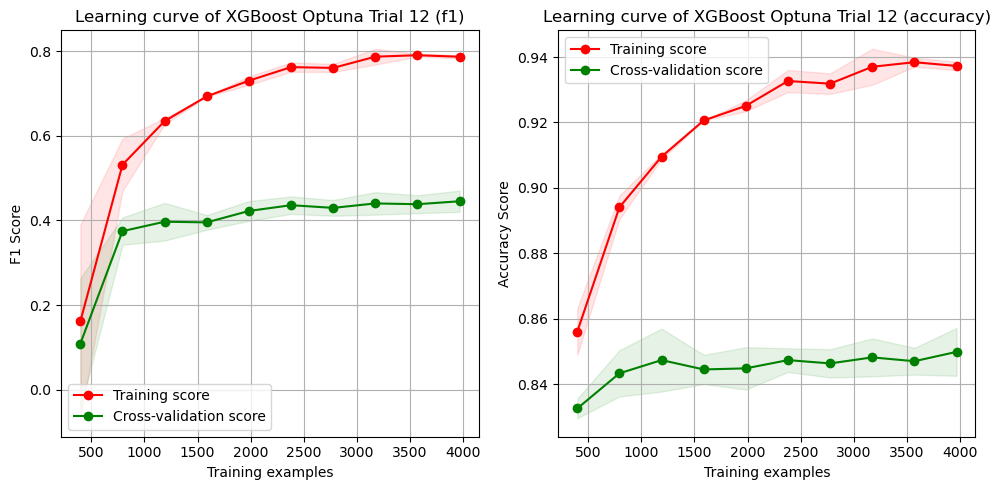

In [65]:
plot_learning_curve(XGBClassifier(**best_params12), X_train_transformed, y_train, "XGBoost Optuna Trial 12", cv=3, n_jobs=-1)

In [66]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.2)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
        'alpha': trial.suggest_float('alpha', 0.1, 1.0),
        'lambda': trial.suggest_float('lambda', 0.5, 1.5),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

best_params13 = study.best_params
print(best_params13)

[I 2023-07-21 17:35:52,723] A new study created in memory with name: no-name-4062b87c-b8b4-4775-82cc-3660e52005e4
[I 2023-07-21 17:35:53,578] Trial 0 finished with value: 0.45267489711934156 and parameters: {'n_estimators': 144, 'learning_rate': 0.19063571821788408, 'max_depth': 6, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.46798356100860794, 'min_child_weight': 5, 'alpha': 0.8795585311974417, 'lambda': 1.1011150117432087}. Best is trial 0 with value: 0.45267489711934156.
[I 2023-07-21 17:35:54,913] Trial 1 finished with value: 0.44600938967136144 and parameters: {'n_estimators': 227, 'learning_rate': 0.013911053916202464, 'max_depth': 7, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.5454749016213019, 'min_child_weight': 7, 'alpha': 0.373818018663584, 'lambda': 1.024756431632238}. Best is trial 0 with value: 0.45267489711934156.
[I 2023-07-21 17:35:55,733] Trial 2 finished with value: 0.4557522123893806 and 

[I 2023-07-21 17:36:10,936] Trial 21 finished with value: 0.4434589800443459 and parameters: {'n_estimators': 96, 'learning_rate': 0.09622108357459921, 'max_depth': 5, 'subsample': 0.7987174558054256, 'colsample_bytree': 0.8216878627452651, 'gamma': 2.9466651254347256, 'min_child_weight': 19, 'alpha': 0.511994720103832, 'lambda': 1.232197170600411}. Best is trial 17 with value: 0.5035294117647059.
[I 2023-07-21 17:36:11,495] Trial 22 finished with value: 0.42542787286063566 and parameters: {'n_estimators': 65, 'learning_rate': 0.09307226339618069, 'max_depth': 4, 'subsample': 0.7519167683272655, 'colsample_bytree': 0.7658313612926887, 'gamma': 2.594179769185116, 'min_child_weight': 16, 'alpha': 0.5356999353561639, 'lambda': 1.3969861508161212}. Best is trial 17 with value: 0.5035294117647059.
[I 2023-07-21 17:36:12,147] Trial 23 finished with value: 0.48130841121495327 and parameters: {'n_estimators': 84, 'learning_rate': 0.1327522596208637, 'max_depth': 5, 'subsample': 0.8144835489951

[I 2023-07-21 17:36:27,745] Trial 42 finished with value: 0.44642857142857145 and parameters: {'n_estimators': 113, 'learning_rate': 0.17403692541820265, 'max_depth': 5, 'subsample': 0.8002674634176887, 'colsample_bytree': 0.7149526879838392, 'gamma': 2.676416831791068, 'min_child_weight': 17, 'alpha': 0.916604470165765, 'lambda': 1.4374950231758825}. Best is trial 17 with value: 0.5035294117647059.
[I 2023-07-21 17:36:28,494] Trial 43 finished with value: 0.43661971830985913 and parameters: {'n_estimators': 89, 'learning_rate': 0.1434811972770598, 'max_depth': 6, 'subsample': 0.7396791781971572, 'colsample_bytree': 0.6816603686941243, 'gamma': 2.489957916505592, 'min_child_weight': 19, 'alpha': 0.8406546300556832, 'lambda': 1.446896530391612}. Best is trial 17 with value: 0.5035294117647059.
[I 2023-07-21 17:36:29,395] Trial 44 finished with value: 0.44695259593679465 and parameters: {'n_estimators': 138, 'learning_rate': 0.18503717826752122, 'max_depth': 5, 'subsample': 0.87428742118

[I 2023-07-21 17:36:48,059] Trial 63 finished with value: 0.42227378190255227 and parameters: {'n_estimators': 121, 'learning_rate': 0.1386122824078613, 'max_depth': 4, 'subsample': 0.7380092803786197, 'colsample_bytree': 0.7932667183066887, 'gamma': 2.5155820873186334, 'min_child_weight': 17, 'alpha': 0.7174314366298998, 'lambda': 1.3804987957033061}. Best is trial 17 with value: 0.5035294117647059.
[I 2023-07-21 17:36:49,527] Trial 64 finished with value: 0.437636761487965 and parameters: {'n_estimators': 300, 'learning_rate': 0.15415201025850192, 'max_depth': 6, 'subsample': 0.7497005342398182, 'colsample_bytree': 0.8134199684534174, 'gamma': 2.918678612111093, 'min_child_weight': 14, 'alpha': 0.6577047747338549, 'lambda': 1.4642734726246844}. Best is trial 17 with value: 0.5035294117647059.
[I 2023-07-21 17:36:50,099] Trial 65 finished with value: 0.48847926267281105 and parameters: {'n_estimators': 79, 'learning_rate': 0.1154416248131741, 'max_depth': 3, 'subsample': 0.76043805951

[I 2023-07-21 17:37:04,230] Trial 84 finished with value: 0.4418052256532066 and parameters: {'n_estimators': 107, 'learning_rate': 0.10048577395148382, 'max_depth': 7, 'subsample': 0.7788718355857568, 'colsample_bytree': 0.6863813052414665, 'gamma': 2.7899713020963803, 'min_child_weight': 10, 'alpha': 0.8320252911771042, 'lambda': 1.4793462154740125}. Best is trial 82 with value: 0.5565217391304348.
[I 2023-07-21 17:37:05,059] Trial 85 finished with value: 0.405727923627685 and parameters: {'n_estimators': 123, 'learning_rate': 0.10750471170708946, 'max_depth': 7, 'subsample': 0.7658686832576108, 'colsample_bytree': 0.7014166503611047, 'gamma': 2.864546411460475, 'min_child_weight': 18, 'alpha': 0.8740637475353816, 'lambda': 1.3628317912085066}. Best is trial 82 with value: 0.5565217391304348.
[I 2023-07-21 17:37:05,972] Trial 86 finished with value: 0.4949290060851927 and parameters: {'n_estimators': 148, 'learning_rate': 0.11363608861826405, 'max_depth': 7, 'subsample': 0.7279273400

{'n_estimators': 99, 'learning_rate': 0.10119446180147644, 'max_depth': 7, 'subsample': 0.7507890775151778, 'colsample_bytree': 0.6819755322916344, 'gamma': 2.78454221681971, 'min_child_weight': 18, 'alpha': 0.8251451504725744, 'lambda': 1.4489670135190198}


In [67]:
clf = XGBClassifier(**best_params13)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 13", best_params13, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."
6,XGBoost Optuna Trial 7,0.860165,155,79,2041,278,0.662393,0.357968,0.660352,0.537419,0.464768,0.394201,"{'n_estimators': 241, 'learning_rate': 0.07692..."
7,XGBoost Optuna Trial 8,0.857814,147,77,2043,286,0.656250,0.339492,0.651586,0.552280,0.447489,0.375767,"{'n_estimators': 290, 'learning_rate': 0.07109..."
8,XGBoost Optuna Trial 9,0.860948,152,74,2046,281,0.672566,0.351039,0.658067,0.551865,0.461305,0.388151,"{'n_estimators': 185, 'learning_rate': 0.09675..."
9,XGBoost Optuna Trial 10,0.858989,134,61,2059,299,0.687179,0.309469,0.640348,0.542024,0.426752,0.347691,"{'n_estimators': 145, 'learning_rate': 0.04888..."


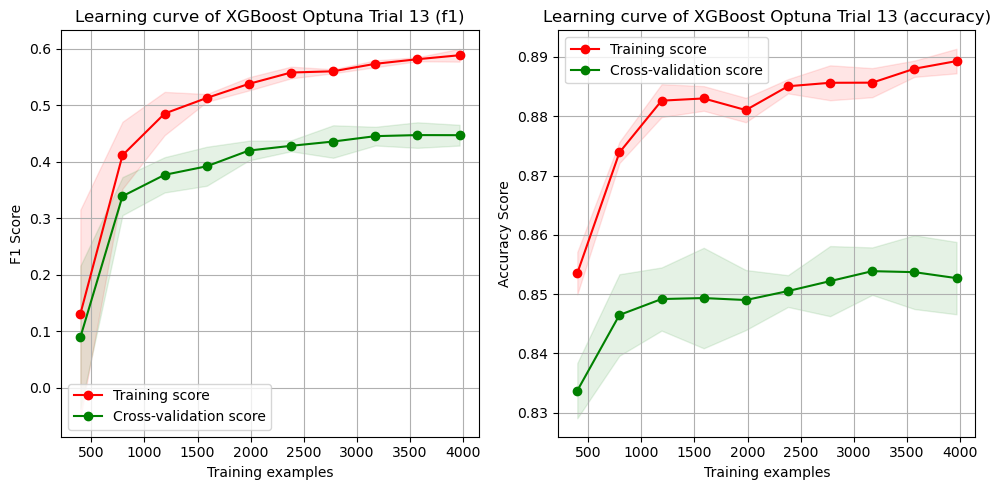

In [68]:
plot_learning_curve(XGBClassifier(**best_params13), X_train_transformed, y_train, "XGBoost Optuna Trial 13", cv=3, n_jobs=-1)

In [69]:
df_results_base["best_params"] = "Default"
df_results.rename(columns={"model": "method"}, inplace=True)
df_results_cv.rename(columns={"model": "method"}, inplace=True)
all_results = pd.concat([df_results_base, df_results_cv, df_results])
all_results.reset_index(drop = True, inplace = True)
all_results

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,LogisticRegression,0.846455,89,48,2072,344,0.649635,0.205543,0.591451,0.489488,0.312281,0.238095,Default
1,KNeighborsClassifier,0.819036,121,150,1970,312,0.446494,0.279446,0.604346,0.370538,0.343750,0.302047,Default
2,SVC,0.830396,0,0,2120,433,0.000000,0.000000,0.500000,0.445788,0.000000,NaN,Default
3,RandomForestClassifier,0.856639,129,62,2058,304,0.675393,0.297921,0.634338,0.526672,0.413462,0.335413,Default
4,GradientBoostingClassifier,0.858598,140,68,2052,293,0.673077,0.323326,0.645625,0.537484,0.436817,0.360825,Default
5,XGBClassifier,0.849980,152,102,2018,281,0.598425,0.351039,0.651463,0.514830,0.442504,0.382679,Default
6,RandomForestClassifier_CV,0.860556,133,56,2064,300,0.703704,0.307159,0.640372,0.536414,0.427653,0.346174,"{'max_depth': 20, 'min_samples_split': 2, 'n_e..."
7,GradientBoostingClassifier_CV,0.852722,144,87,2033,289,0.623377,0.332564,0.645763,0.523576,0.433735,0.366786,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
8,XGBClassifier_CV,0.840188,157,132,1988,276,0.543253,0.362587,0.650161,0.468957,0.434903,0.388422,"{'learning_rate': 1, 'max_depth': 5, 'n_estima..."
9,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."


In [70]:
def objective(trial: Trial, X, y):
    X_train, X_valid, y_train, y_valid = mod.train_test_split(X, y, test_size=0.3)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 250),
        'learning_rate': trial.suggest_float('learning_rate', 0.05 , 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 4),
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 15, 25),
        'alpha': trial.suggest_float('alpha', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.5, 2.0),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    X_train_transformed = preprocessing_pipeline.fit_transform(X_train.reset_index(drop = True))
    X_valid_transformed = preprocessing_pipeline.transform(X_valid.reset_index(drop = True))

    model.fit(X_train_transformed, y_train)
    
    y_pred = model.predict(X_valid_transformed)
    score = met.f1_score(y_valid, y_pred)

    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials=200)

best_params14 = study.best_params
print(best_params14)

[I 2023-07-21 17:37:23,335] A new study created in memory with name: no-name-f83fe0d0-5185-4a1b-91a4-45e76e79ce61
[I 2023-07-21 17:37:23,982] Trial 0 finished with value: 0.4655436447166922 and parameters: {'n_estimators': 187, 'learning_rate': 0.09753571532049582, 'max_depth': 3, 'subsample': 0.5197316968394073, 'colsample_bytree': 0.43120372808848734, 'gamma': 0.7799726016810132, 'min_child_weight': 15, 'alpha': 0.9330880728874675, 'lambda': 1.4016725176148133}. Best is trial 0 with value: 0.4655436447166922.
[I 2023-07-21 17:37:24,834] Trial 1 finished with value: 0.43533123028391163 and parameters: {'n_estimators': 221, 'learning_rate': 0.05102922471479013, 'max_depth': 4, 'subsample': 0.5664885281600843, 'colsample_bytree': 0.4424678221356552, 'gamma': 0.9091248360355031, 'min_child_weight': 17, 'alpha': 0.6521211214797689, 'lambda': 1.2871346474483567}. Best is trial 0 with value: 0.4655436447166922.
[I 2023-07-21 17:37:25,504] Trial 2 finished with value: 0.4573991031390135 and 

[I 2023-07-21 17:37:39,260] Trial 21 finished with value: 0.4773060029282577 and parameters: {'n_estimators': 228, 'learning_rate': 0.07545471241833673, 'max_depth': 3, 'subsample': 0.5171811960960421, 'colsample_bytree': 0.4186072355557765, 'gamma': 0.36955997625624687, 'min_child_weight': 19, 'alpha': 0.8549716710762605, 'lambda': 1.5947139181455126}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:37:40,049] Trial 22 finished with value: 0.46788990825688076 and parameters: {'n_estimators': 230, 'learning_rate': 0.07353154612091171, 'max_depth': 3, 'subsample': 0.5294595364429175, 'colsample_bytree': 0.4172631525290322, 'gamma': 0.3501244523572158, 'min_child_weight': 19, 'alpha': 0.844963860820078, 'lambda': 1.639845008185164}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:37:40,843] Trial 23 finished with value: 0.4635958395245171 and parameters: {'n_estimators': 234, 'learning_rate': 0.07414310446970122, 'max_depth': 3, 'subsample': 0.504129

[I 2023-07-21 17:37:55,100] Trial 42 finished with value: 0.48551724137931035 and parameters: {'n_estimators': 228, 'learning_rate': 0.08728874406738407, 'max_depth': 4, 'subsample': 0.5710805365179793, 'colsample_bytree': 0.41286982707422115, 'gamma': 0.37840628638081863, 'min_child_weight': 18, 'alpha': 0.7631553094760695, 'lambda': 1.9063256750054889}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:37:55,916] Trial 43 finished with value: 0.4378881987577639 and parameters: {'n_estimators': 227, 'learning_rate': 0.07561648535957119, 'max_depth': 3, 'subsample': 0.5755135310075898, 'colsample_bytree': 0.4262659095820361, 'gamma': 0.3874150583347249, 'min_child_weight': 18, 'alpha': 0.8212603876407403, 'lambda': 1.7300574689208355}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:37:56,730] Trial 44 finished with value: 0.450920245398773 and parameters: {'n_estimators': 235, 'learning_rate': 0.08242966511147028, 'max_depth': 3, 'subsample': 0.5719

[I 2023-07-21 17:38:10,731] Trial 63 finished with value: 0.44511278195488724 and parameters: {'n_estimators': 157, 'learning_rate': 0.08167028919286289, 'max_depth': 4, 'subsample': 0.5265454215534726, 'colsample_bytree': 0.42198628007354116, 'gamma': 1.2545024327176024, 'min_child_weight': 18, 'alpha': 0.7837555035153366, 'lambda': 1.882290986746595}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:38:11,588] Trial 64 finished with value: 0.4670658682634731 and parameters: {'n_estimators': 234, 'learning_rate': 0.08487550291793886, 'max_depth': 4, 'subsample': 0.5315794611053857, 'colsample_bytree': 0.4064999905115637, 'gamma': 0.31646705065802916, 'min_child_weight': 18, 'alpha': 0.758296962646454, 'lambda': 1.822911828936872}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:38:12,428] Trial 65 finished with value: 0.4667697063369397 and parameters: {'n_estimators': 224, 'learning_rate': 0.07820760874890846, 'max_depth': 4, 'subsample': 0.510484

[I 2023-07-21 17:38:27,346] Trial 84 finished with value: 0.48138297872340424 and parameters: {'n_estimators': 240, 'learning_rate': 0.07822255670606043, 'max_depth': 3, 'subsample': 0.5153037247983586, 'colsample_bytree': 0.4170342689944012, 'gamma': 0.5992641541369507, 'min_child_weight': 19, 'alpha': 0.8563705963139632, 'lambda': 1.9071715473744268}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:38:28,153] Trial 85 finished with value: 0.41124260355029585 and parameters: {'n_estimators': 240, 'learning_rate': 0.07796341716945909, 'max_depth': 3, 'subsample': 0.5163919568220565, 'colsample_bytree': 0.43055381492453176, 'gamma': 0.6303814235357796, 'min_child_weight': 19, 'alpha': 0.8635042505640652, 'lambda': 1.8929212200226055}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:38:28,908] Trial 86 finished with value: 0.49262536873156343 and parameters: {'n_estimators': 248, 'learning_rate': 0.08166907050307241, 'max_depth': 2, 'subsample': 0.50

[I 2023-07-21 17:38:44,723] Trial 105 finished with value: 0.4608695652173913 and parameters: {'n_estimators': 233, 'learning_rate': 0.07968216351427305, 'max_depth': 4, 'subsample': 0.5808004303518459, 'colsample_bytree': 0.43179156326932294, 'gamma': 0.9039825199066227, 'min_child_weight': 16, 'alpha': 0.7740129204760197, 'lambda': 1.7457555884772646}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:38:45,478] Trial 106 finished with value: 0.44541484716157204 and parameters: {'n_estimators': 174, 'learning_rate': 0.07389092548339925, 'max_depth': 4, 'subsample': 0.5654228317211513, 'colsample_bytree': 0.4226015143051561, 'gamma': 0.6622589885772183, 'min_child_weight': 18, 'alpha': 0.807428797530354, 'lambda': 1.9074588307725582}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:38:46,341] Trial 107 finished with value: 0.46575342465753433 and parameters: {'n_estimators': 226, 'learning_rate': 0.07572332060670171, 'max_depth': 4, 'subsample': 0.5

[I 2023-07-21 17:39:01,723] Trial 126 finished with value: 0.45410628019323673 and parameters: {'n_estimators': 163, 'learning_rate': 0.07735173321851802, 'max_depth': 4, 'subsample': 0.5634166377436781, 'colsample_bytree': 0.40451300239740046, 'gamma': 0.27124945558486263, 'min_child_weight': 19, 'alpha': 0.7428255447918184, 'lambda': 1.77892435964327}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:39:02,493] Trial 127 finished with value: 0.423963133640553 and parameters: {'n_estimators': 219, 'learning_rate': 0.09205226416553346, 'max_depth': 3, 'subsample': 0.5066890236299788, 'colsample_bytree': 0.41348765920774944, 'gamma': 0.46589262891448907, 'min_child_weight': 18, 'alpha': 0.7781270558123331, 'lambda': 1.933740951298922}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:39:03,200] Trial 128 finished with value: 0.4583333333333333 and parameters: {'n_estimators': 208, 'learning_rate': 0.08039906777641803, 'max_depth': 2, 'subsample': 0.55

[I 2023-07-21 17:39:17,025] Trial 147 finished with value: 0.44929797191887677 and parameters: {'n_estimators': 190, 'learning_rate': 0.07634966199748162, 'max_depth': 3, 'subsample': 0.5319899426366358, 'colsample_bytree': 0.4595506730508754, 'gamma': 0.47022571868039675, 'min_child_weight': 18, 'alpha': 0.7984474151047721, 'lambda': 1.790203011236475}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:39:17,818] Trial 148 finished with value: 0.44544095665171896 and parameters: {'n_estimators': 200, 'learning_rate': 0.07458936298260098, 'max_depth': 3, 'subsample': 0.5097957060827436, 'colsample_bytree': 0.47873601023954215, 'gamma': 0.004651299379140397, 'min_child_weight': 19, 'alpha': 0.8916544781636799, 'lambda': 1.3397278904209229}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:39:18,534] Trial 149 finished with value: 0.455108359133127 and parameters: {'n_estimators': 182, 'learning_rate': 0.0811776489863207, 'max_depth': 3, 'subsample': 0.

[I 2023-07-21 17:39:33,302] Trial 168 finished with value: 0.44878048780487806 and parameters: {'n_estimators': 227, 'learning_rate': 0.0778394093390016, 'max_depth': 3, 'subsample': 0.574413182009539, 'colsample_bytree': 0.40841112726342615, 'gamma': 1.2293479569268846, 'min_child_weight': 19, 'alpha': 0.7740531251596227, 'lambda': 1.544541009222732}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:39:34,109] Trial 169 finished with value: 0.4216867469879518 and parameters: {'n_estimators': 228, 'learning_rate': 0.07676549421716643, 'max_depth': 3, 'subsample': 0.5986039557987204, 'colsample_bytree': 0.452926962671861, 'gamma': 0.20589789471684583, 'min_child_weight': 19, 'alpha': 0.9198603377520419, 'lambda': 1.6451386404966575}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:39:34,902] Trial 170 finished with value: 0.42040185471406494 and parameters: {'n_estimators': 221, 'learning_rate': 0.07930360387837372, 'max_depth': 3, 'subsample': 0.582

[I 2023-07-21 17:39:50,421] Trial 189 finished with value: 0.4247787610619469 and parameters: {'n_estimators': 196, 'learning_rate': 0.07372413971005229, 'max_depth': 4, 'subsample': 0.4923486211077572, 'colsample_bytree': 0.4025885691645644, 'gamma': 1.1967644347452466, 'min_child_weight': 22, 'alpha': 0.9893644196819099, 'lambda': 1.864092395745532}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:39:51,220] Trial 190 finished with value: 0.45468509984639016 and parameters: {'n_estimators': 202, 'learning_rate': 0.07231691156902859, 'max_depth': 4, 'subsample': 0.5106103988095065, 'colsample_bytree': 0.4315225454392307, 'gamma': 1.3837867096667493, 'min_child_weight': 21, 'alpha': 0.7695920802482855, 'lambda': 1.9256339899471477}. Best is trial 19 with value: 0.49931412894375854.
[I 2023-07-21 17:39:52,073] Trial 191 finished with value: 0.4467455621301775 and parameters: {'n_estimators': 232, 'learning_rate': 0.07826648190053745, 'max_depth': 4, 'subsample': 0.516

{'n_estimators': 230, 'learning_rate': 0.0834406581377351, 'max_depth': 3, 'subsample': 0.5105935045749272, 'colsample_bytree': 0.4229368175885292, 'gamma': 0.04075927869243545, 'min_child_weight': 19, 'alpha': 0.8534590584260753, 'lambda': 1.6344175916183725}


In [71]:
clf = XGBClassifier(**best_params14)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
TN, FP, FN, TP = met.confusion_matrix(y_test, y_pred).ravel()

accuracy = met.accuracy_score(y_test, y_pred)
precision = met.precision_score(y_test, y_pred)
recall = met.recall_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)
roc_auc = met.roc_auc_score(y_test, y_pred)

y_score = clf.predict_proba(X_test_transformed)[:, 1]
precision_, recall_, _ = met.precision_recall_curve(y_test, y_score)
pr_auc = met.auc(recall_, precision_)

beta = 2
f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

results.append(["XGBoost Optuna Trial 14", best_params14, accuracy, TP, FP, TN, FN, precision, recall, roc_auc, pr_auc, f1, f2])

df_results = pd.DataFrame(results, columns=["model", "best_params", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2"])
df_results = df_results[["model", "accuracy", "TP", "FP", "TN", "FN", "precision", "recall", "roc_auc", "pr_auc", "f1", "f2", "best_params"]]
df_results

,model,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2,best_params
0,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217,"{'n_estimators': 540, 'learning_rate': 0.08437..."
1,XGBoost Optuna Trial 2,0.853897,154,94,2026,279,0.620968,0.355658,0.655659,0.520445,0.452276,0.388889,"{'n_estimators': 268, 'learning_rate': 0.08408..."
2,XGBoost Optuna Trial 3,0.854681,177,115,2005,256,0.606164,0.408776,0.677265,0.513095,0.488276,0.437253,"{'n_estimators': 514, 'learning_rate': 0.29482..."
3,XGBoost Optuna Trial 4,0.849980,159,109,2011,274,0.593284,0.367206,0.657895,0.513475,0.453638,0.397500,"{'n_estimators': 1926, 'learning_rate': 0.1228..."
4,XGBoost Optuna Trial 5,0.855856,163,98,2022,270,0.624521,0.376443,0.665109,0.530743,0.469741,0.408931,"{'n_estimators': 793, 'learning_rate': 0.15825..."
5,XGBoost Optuna Trial 6,0.853506,157,98,2022,276,0.615686,0.362587,0.658180,0.518259,0.456395,0.395068,"{'n_estimators': 163, 'learning_rate': 0.16383..."
6,XGBoost Optuna Trial 7,0.860165,155,79,2041,278,0.662393,0.357968,0.660352,0.537419,0.464768,0.394201,"{'n_estimators': 241, 'learning_rate': 0.07692..."
7,XGBoost Optuna Trial 8,0.857814,147,77,2043,286,0.656250,0.339492,0.651586,0.552280,0.447489,0.375767,"{'n_estimators': 290, 'learning_rate': 0.07109..."
8,XGBoost Optuna Trial 9,0.860948,152,74,2046,281,0.672566,0.351039,0.658067,0.551865,0.461305,0.388151,"{'n_estimators': 185, 'learning_rate': 0.09675..."
9,XGBoost Optuna Trial 10,0.858989,134,61,2059,299,0.687179,0.309469,0.640348,0.542024,0.426752,0.347691,"{'n_estimators': 145, 'learning_rate': 0.04888..."


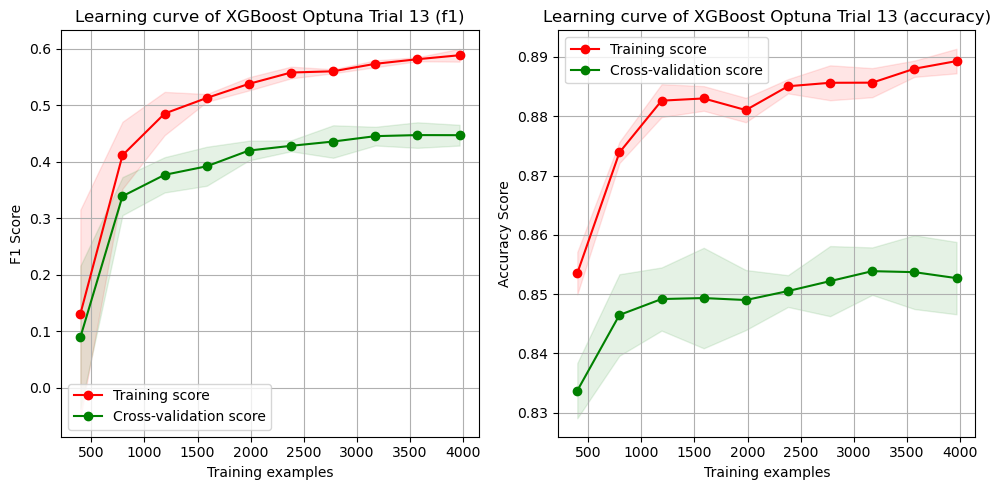

In [72]:
plot_learning_curve(XGBClassifier(**best_params13), X_train_transformed, y_train, "XGBoost Optuna Trial 13", cv=3, n_jobs=-1)

In [73]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

all_results[all_results.columns[:-1]].style.apply(highlight_max, subset=['accuracy', 'TP', 'TN', 'precision','recall','roc_auc','pr_auc','f1','f2']).\
                                            apply(highlight_max, subset=['FP','FN']).\
                                            apply(highlight_min, subset=['FP','FN']).\
                                            set_table_styles([
                                                            {'selector': 'th', 'props': [('border', '1px solid black')]},
                                                            {'selector': 'td', 'props': [('border', '1px solid black')]}
                                                        ])


,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,LogisticRegression,0.846455,89,48,2072,344,0.649635,0.205543,0.591451,0.489488,0.312281,0.238095
1,KNeighborsClassifier,0.819036,121,150,1970,312,0.446494,0.279446,0.604346,0.370538,0.343750,0.302047
2,SVC,0.830396,0,0,2120,433,0.000000,0.000000,0.500000,0.445788,0.000000,nan
3,RandomForestClassifier,0.856639,129,62,2058,304,0.675393,0.297921,0.634338,0.526672,0.413462,0.335413
4,GradientBoostingClassifier,0.858598,140,68,2052,293,0.673077,0.323326,0.645625,0.537484,0.436817,0.360825
5,XGBClassifier,0.849980,152,102,2018,281,0.598425,0.351039,0.651463,0.514830,0.442504,0.382679
6,RandomForestClassifier_CV,0.860556,133,56,2064,300,0.703704,0.307159,0.640372,0.536414,0.427653,0.346174
7,GradientBoostingClassifier_CV,0.852722,144,87,2033,289,0.623377,0.332564,0.645763,0.523576,0.433735,0.366786
8,XGBClassifier_CV,0.840188,157,132,1988,276,0.543253,0.362587,0.650161,0.468957,0.434903,0.388422
9,XGBoost Optuna Trial 1,0.854289,155,94,2026,278,0.622490,0.357968,0.656814,0.523178,0.454545,0.391217


## Conclusion

Some of the models have underfitted the dataset while others have overfitted. If I had more time, I would:
- Check the feature importances and try to fit the models with different combinations of features.
- Try oversampling and undersampling to deal with the class imbalance.
- Attempt to tune my models with different hyperparameters.
- Pursue more feature engineering to better separate the target class.

I would be happy to discuss other possible improvements that could be made in an office environment :)